In [1]:
import os
import glob
import warnings
import pickle
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
import optuna
import xgboost as xgb
import multiprocessing

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow_model_optimization as tfmot

from optuna.integration import TFKerasPruningCallback
# from scikeras.wrappers import KerasClassifier
from keras.callbacks import ModelCheckpoint

# import tf_keras as keras 

warnings.filterwarnings("ignore", message="``build_fn`` will be renamed")


2024-10-25 23:12:45.288422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
num_cpu_cores = multiprocessing.cpu_count()
print(f"Number of available CPU cores: {num_cpu_cores}")

Number of available CPU cores: 44


In [2]:
print(os.getcwd())

/project/6002348/fdehrouy/eric/BelugaVersion


In [3]:
def CombineCSVs(folder_path):
    # Use glob to get all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    # The result is a list of file paths,
    # where each element in the list is the path to a single CSV fil.

    # # Print the list of CSV file paths
    # print(csv_files)
    
    # Initialize a list to hold each DataFrame and a set to keep track of column names
    data_frames = []
    columns_set = set()
    
    # first_address = csv_files[0]
    # df = pd.read_csv(first_address, low_memory=False)
    
    # Loop through the list of CSV files and read each one into a DataFrame
    for file in csv_files:
        df = pd.read_csv(file, low_memory=False)
        data_frames.append(df)
        # Add the column names of the current file to the set
        columns_set.update(df.columns)

    # After the loop, data_frames is a list where each element is a separate DataFrame,
    # corresponding to one of the CSV files read. 
    
    # print(len(data_frames))
    # print(len(csv_files))

    # Check if all DataFrames have the same columns
    consistent_features = all(set(df.columns) == columns_set for df in data_frames)

    if consistent_features:
        feature_names = list(columns_set)
        # print("The features are consistent in all the files. Here are the features:")
        # print(feature_names)
    else:
        print("The features are not consistent across all files.")
        
    # Combine all DataFrames into a single DataFrame
    combined_data = pd.concat(data_frames, ignore_index=True)

    # print(type(combined_data))
    # print(len(feature_names))
    # print(combined_data.shape[1])
    # print(combined_data.shape[0] == sum(data_frames[i].shape[0] for i in range(len(data_frames))))
    
    return combined_data

In [4]:
Network_TrafficA = CombineCSVs('/project/6002348/fdehrouy/eric/BelugaVersion/A/')
Network_TrafficB = CombineCSVs('/project/6002348/fdehrouy/eric/BelugaVersion/B/')

In [5]:
df_all = pd.concat([Network_TrafficA, Network_TrafficB], ignore_index = True)

In [24]:
df_all.columns

Index(['time', 'length', 'src_ip', 'src_mac', 'src_oui', 'src_port', 'dst_ip',
       'dst_mac', 'dst_oui', 'dst_port', 'protocol', 'ip_version', 'vlan_id',
       'tunnel_id', 'bidirectional_first_seen_ms',
       'bidirectional_last_seen_ms', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_first_seen_ms',
       'src2dst_last_seen_ms', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_first_seen_ms', 'dst2src_last_seen_ms',
       'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'bidirectional_min_ps', 'bidirectional_mean_ps',
       'bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps',
       'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps',
       'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'dst2src_max_ps', 'bidirectional_min_piat_ms',
       'bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_

In [25]:
len(df_all.columns)

86

In [6]:
# id: Unique identifier for each record.
# expiration_id: Identifier indicating the expiration status of the record.
# src_ip: Source IP address from where the packet originated.
# src_mac: Source MAC address from where the packet originated.
# src_oui: Organizationally Unique Identifier for the source MAC address.
# src_port: Source port number from where the packet originated.
# dst_ip: Destination IP address where the packet is being sent.
# dst_mac: Destination MAC address where the packet is being sent.
# dst_oui: Organizationally Unique Identifier for the destination MAC address.
# dst_port: Destination port number where the packet is being sent.
# protocol: Protocol used for the communication (e.g., TCP, UDP).
# ip_version: Version of the IP protocol (e.g., IPv4, IPv6).
# vlan_id: Virtual LAN identifier associated with the packet.
# tunnel_id: Identifier for the tunnel through which the packet is transmitted.
# bidirectional_first_seen_ms: Timestamp in milliseconds when the bidirectional communication was first seen.
# bidirectional_last_seen_ms: Timestamp in milliseconds when the bidirectional communication was last seen.
# bidirectional_duration_ms: Duration in milliseconds of the bidirectional communication.
# bidirectional_packets: Total number of packets exchanged bidirectionally.
# bidirectional_bytes: Total number of bytes exchanged bidirectionally.
# src2dst_first_seen_ms: Timestamp in milliseconds when the source-to-destination communication was first seen.
# src2dst_last_seen_ms: Timestamp in milliseconds when the source-to-destination communication was last seen.
# src2dst_duration_ms: Duration in milliseconds of the source-to-destination communication.
# src2dst_packets: Total number of packets sent from source to destination.
# src2dst_bytes: Total number of bytes sent from source to destination.
# dst2src_first_seen_ms: Timestamp in milliseconds when the destination-to-source communication was first seen.
# dst2src_last_seen_ms: Timestamp in milliseconds when the destination-to-source communication was last seen.
# dst2src_duration_ms: Duration in milliseconds of the destination-to-source communication.
# dst2src_packets: Total number of packets sent from destination to source.
# dst2src_bytes: Total number of bytes sent from destination to source.
# bidirectional_min_ps: Minimum packet size observed in bidirectional communication.
# bidirectional_mean_ps: Mean packet size in bidirectional communication.
# bidirectional_stddev_ps: Standard deviation of packet sizes in bidirectional communication.
# bidirectional_max_ps: Maximum packet size observed in bidirectional communication.
# src2dst_min_ps: Minimum packet size observed from source to destination.
# src2dst_mean_ps: Mean packet size from source to destination.
# src2dst_stddev_ps: Standard deviation of packet sizes from source to destination.
# src2dst_max_ps: Maximum packet size observed from source to destination.
# dst2src_min_ps: Minimum packet size observed from destination to source.
# dst2src_mean_ps: Mean packet size from destination to source.
# dst2src_stddev_ps: Standard deviation of packet sizes from destination to source.
# dst2src_max_ps: Maximum packet size observed from destination to source.
# bidirectional_min_piat_ms: Minimum packet inter-arrival time in milliseconds for bidirectional communication.
# bidirectional_mean_piat_ms: Mean packet inter-arrival time in milliseconds for bidirectional communication.
# bidirectional_stddev_piat_ms: Standard deviation of packet inter-arrival times in milliseconds for bidirectional communication.
# bidirectional_max_piat_ms: Maximum packet inter-arrival time in milliseconds for bidirectional communication.
# src2dst_min_piat_ms: Minimum packet inter-arrival time in milliseconds from source to destination.
# src2dst_mean_piat_ms: Mean packet inter-arrival time in milliseconds from source to destination.
# src2dst_stddev_piat_ms: Standard deviation of packet inter-arrival times in milliseconds from source to destination.
# src2dst_max_piat_ms: Maximum packet inter-arrival time in milliseconds from source to destination.
# dst2src_min_piat_ms: Minimum packet inter-arrival time in milliseconds from destination to source.
# dst2src_mean_piat_ms: Mean packet inter-arrival time in milliseconds from destination to source.
# dst2src_stddev_piat_ms: Standard deviation of packet inter-arrival times in milliseconds from destination to source.
# dst2src_max_piat_ms: Maximum packet inter-arrival time in milliseconds from destination to source.
# bidirectional_syn_packets: Number of SYN packets exchanged bidirectionally.
# bidirectional_cwr_packets: Number of Congestion Window Reduced (CWR) packets exchanged bidirectionally.
# bidirectional_ece_packets: Number of Explicit Congestion Notification Echo (ECE) packets exchanged bidirectionally.
# bidirectional_urg_packets: Number of URG (urgent) packets exchanged bidirectionally.
# bidirectional_ack_packets: Number of ACK (acknowledgment) packets exchanged bidirectionally.
# bidirectional_psh_packets: Number of PSH (push) packets exchanged bidirectionally.
# bidirectional_rst_packets: Number of RST (reset) packets exchanged bidirectionally.
# bidirectional_fin_packets: Number of FIN (finish) packets exchanged bidirectionally.
# src2dst_syn_packets: Number of SYN packets sent from source to destination.
# src2dst_cwr_packets: Number of CWR packets sent from source to destination.
# src2dst_ece_packets: Number of ECE packets sent from source to destination.
# src2dst_urg_packets: Number of URG packets sent from source to destination.
# src2dst_ack_packets: Number of ACK packets sent from source to destination.
# src2dst_psh_packets: Number of PSH packets sent from source to destination.
# src2dst_rst_packets: Number of RST packets sent from source to destination.
# src2dst_fin_packets: Number of FIN packets sent from source to destination.
# dst2src_syn_packets: Number of SYN packets sent from destination to source.
# dst2src_cwr_packets: Number of CWR packets sent from destination to source.
# dst2src_ece_packets: Number of ECE packets sent from destination to source.
# dst2src_urg_packets: Number of URG packets sent from destination to source.
# dst2src_ack_packets: Number of ACK packets sent from destination to source.
# dst2src_psh_packets: Number of PSH packets sent from destination to source.
# dst2src_rst_packets: Number of RST packets sent from destination to source.
# dst2src_fin_packets: Number of FIN packets sent from destination to source.
# application_name: Name of the application associated with the packet.
# application_category_name: Category of the application associated with the packet.
# application_is_guessed: Indicator of whether the application identification is guessed.
# application_confidence: Confidence level in the application identification.
# requested_server_name: Name of the server requested by the client.
# client_fingerprint: Fingerprint of the client device.
# server_fingerprint: Fingerprint of the server.
# user_agent: User agent string of the client device.
# content_type: Type of content being transmitted.

In [7]:
# Check if bidirectional_first_seen_ms is the minimum among the TimeStamps

TimeStamps = ['bidirectional_first_seen_ms',
'bidirectional_last_seen_ms',
'src2dst_first_seen_ms',
'src2dst_last_seen_ms',
'dst2src_first_seen_ms',
'dst2src_last_seen_ms']
    
# counter = 0
# for row in range(len(df_all)):
#     if df_all.loc[row, 'bidirectional_first_seen_ms'] != df_all.loc[row, TimeStamps].min():
#         if df_all.loc[row, TimeStamps].min() != 0:
#             print(df_all.loc[row, TimeStamps].min())
#             counter += 1
# print('The number of rows in which bidirectional_first_seen_ms is not min is:', counter)


# Check for minimum value
is_min = df_all['bidirectional_first_seen_ms'] != df_all[TimeStamps].min(axis = 1)


# Filter out rows where the minimum value is zero
is_min_nonzero = (df_all[TimeStamps].min(axis=1) != 0) & is_min

# Count the number of rows
counter = is_min_nonzero.sum()

# Print the result
print('The number of rows in which bidirectional_first_seen_ms is not min is:', counter)

The number of rows in which bidirectional_first_seen_ms is not min is: 0


In [8]:
# bidirectional_first_seen_ms is Timestamp

In [9]:
# # For each single csv file, check if bidirectional_first_seen_ms is ascending ignoring zeros

# def check_ascending_timestamp(folder_path):
#     # Get all CSV files in the folder
#     csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
#     for file in csv_files:
#         # Read the CSV file
#         df = pd.read_csv(file, low_memory=False)

#         # Filter out rows where 'bidirectional_first_seen_ms' is zero
#         df = df[df['bidirectional_first_seen_ms'] != 0]

#         # Check if the 'bidirectional_first_seen_ms' column is in ascending order
#         is_ascending = df['bidirectional_first_seen_ms'].is_monotonic_increasing

#         if not is_ascending:
#             print(f'The timestamp in file {file} is not ascending!')


# check_ascending_timestamp('/project/6002348/fdehrouy/eric/BelugaVersion/A/')
# check_ascending_timestamp('/project/6002348/fdehrouy/eric/BelugaVersion/B/')

In [10]:
# bidirectional_first_seen_ms is not ascending

In [11]:
# Get the 0 percentage in bidirectional_first_seen_ms and remove them

def handle_zero_values(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    for file in csv_files:
        # Read the CSV file
        df = pd.read_csv(file, low_memory=False)

        # Calculate the number of rows with zero values
        zero_count = (df['bidirectional_first_seen_ms'] == 0).sum()

        # Calculate the percentage of rows with zero values
        total_count = len(df)
        zero_percentage = (zero_count / total_count) * 100
        
        if zero_count !=0:
            # Print the file name and the percentage of zero values
            print(f'File: {file}')
            print(f'Number of rows with zero values: {zero_count}')
            print(f'Percentage of rows with zero values: {zero_percentage:.2f}%')

        
handle_zero_values('/project/6002348/fdehrouy/eric/BelugaVersion/A/')
handle_zero_values('/project/6002348/fdehrouy/eric/BelugaVersion/B/')

In [12]:
# bidirectional_first_seen_ms has no zero values

In [13]:
# Check if the samples of different csv files of each charging station interfere in time or not.

def time_interference_CS(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    # Check for overlap between each pair of files
    for i in range(len(csv_files)):
        for j in range(i + 1, len(csv_files)):
            # Read the first file
            df1 = pd.read_csv(csv_files[i], low_memory=False)
            timestamps1 = df1['bidirectional_first_seen_ms']
            min1, max1 = timestamps1.min(), timestamps1.max()
            
            # Read the second file
            df2 = pd.read_csv(csv_files[j], low_memory=False)
            timestamps2 = df2['bidirectional_first_seen_ms']
            min2, max2 = timestamps2.min(), timestamps2.max()
            
            # Check if the time ranges overlap
            if not (max1 < min2 or max2 < min1):
                return True
    
    # If no pairs overlap, return False
    return False

result = time_interference_CS('/project/6002348/fdehrouy/eric/BelugaVersion/A/')
print(f"Do the files interfere in time for CS A? {'Yes' if result else 'No'}")

result = time_interference_CS('/project/6002348/fdehrouy/eric/BelugaVersion/B/')
print(f"Do the files interfere in time for CS A? {'Yes' if result else 'No'}")

Do the files interfere in time for CS A? No
Do the files interfere in time for CS A? Yes


In [14]:

def process(folder_path, ChargingStation):
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    modified_dfs = []
    
    for file in csv_files:
        # Read the CSV file
        df = pd.read_csv(file, low_memory=False)
        
        # Calculate the mean timestamp
        # Take the mean of the bidirectional_first_seen_ms of each csv file for future sorting
        mean_timestamp = df['bidirectional_first_seen_ms'].mean()
        
        # Add new columns
        df['mean_timestamp'] = mean_timestamp
        df['ChargingStation'] = ChargingStation
        # Names start with 'EVSE-A-' or 'EVSE-B-' and end to '.csv'
        df['CSVNameFile'] = os.path.basename(file)[7:-4]
        
        # Append the modified DataFrame to the list
        modified_dfs.append(df)
        
    return modified_dfs

modified_dfs_A = process('/project/6002348/fdehrouy/eric/BelugaVersion/A/', 'A')
modified_dfs_B = process('/project/6002348/fdehrouy/eric/BelugaVersion/B/', 'B')

In [15]:
df_As = pd.concat(modified_dfs_A)
df_Bs = pd.concat(modified_dfs_B)

In [16]:
# Sort by 'mean_timestamp' and then by 'bidirectional_first_seen_ms', and then by original order
df_As_sorted = df_As.sort_values(by = ['mean_timestamp', 'bidirectional_first_seen_ms'], kind = 'stable')
df_Bs_sorted = df_Bs.sort_values(by = ['mean_timestamp', 'bidirectional_first_seen_ms'], kind = 'stable')

In [17]:
# df_As_sorted['bidirectional_first_seen_ms'].is_monotonic_increasing
# df_Bs_sorted['bidirectional_first_seen_ms'].is_monotonic_increasing

In [18]:
# set(df_Bs_sorted['CSVNameFile']) - set(df_As_sorted['CSVNameFile'])

In [19]:
# For any transition in 'CSVNameFile', capture changes in 'bidirectional_first_seen_ms'

# Function to capture transitions
def capture_transitions(df):
    transitions = []
    previous_file = None
    previous_timestamp = None
    states_seen = set()
    repeated_states = set()

    for i, row in df.iterrows():
        current_file = row['CSVNameFile']
        current_timestamp = row['bidirectional_first_seen_ms']
        
        if previous_file is not None and current_file != previous_file:
            transition = {
                'from': previous_file,
                'from_timestamp': previous_timestamp,
                'to': current_file,
                'to_timestamp': current_timestamp
            }
            transitions.append(transition)
        
        # Check if the state has been seen before
        if current_file in states_seen:
            repeated_states.add(current_file)
        else:
            states_seen.add(current_file)
        
        previous_file = current_file
        previous_timestamp = current_timestamp

    return transitions, repeated_states

# Capture transitions in sorted DataFrames
transitions_A, repeated_states_A = capture_transitions(df_As_sorted)
transitions_B, repeated_states_B = capture_transitions(df_Bs_sorted)


In [20]:
# # Display transitions and repeated states
# print("Transitions A:")
# for transition in transitions_A:
#     print(f"Transition from {transition['from']} to {transition['to']}")
#     print(f"From timestamp: {transition['from_timestamp']}, To timestamp: {transition['to_timestamp']}")

# print("Repeated States A:")
# print(repeated_states_A)

# print("Transitions B:")
# for transition in transitions_B:
#     print(f"Transition from {transition['from']} to {transition['to']}")
#     print(f"From timestamp: {transition['from_timestamp']}, To timestamp: {transition['to_timestamp']}")

# print("Repeated States B:")
# print(repeated_states_B)

In [21]:
# check if A and B interfere in time

minA = df_As_sorted['bidirectional_first_seen_ms'].min()
maxA =df_As_sorted['bidirectional_first_seen_ms'].max()

minB = df_Bs_sorted['bidirectional_first_seen_ms'].min()
maxB = df_Bs_sorted['bidirectional_first_seen_ms'].max()

# Check if the time ranges overlap
# This checks if neither maxA is less than minB nor maxB is less than minA.
interfere = not (maxA < minB or maxB < minA)

if interfere:
    print("Datasets A and B interfere in time.")
else:
    print("Datasets A and B do not interfere in time.")
    

Datasets A and B interfere in time.


In [22]:
df_As_sorted.drop(columns= TimeStamps, inplace = True)
df_Bs_sorted.drop(columns= TimeStamps, inplace = True)

In [23]:
df_As_sorted.drop(columns= ['mean_timestamp'], inplace = True)
df_Bs_sorted.drop(columns= ['mean_timestamp'], inplace = True)

In [26]:
#Preprocessings

In [27]:
df_A = df_As_sorted.copy()
df_B = df_Bs_sorted.copy()

In [28]:
df_A.drop(columns= ['time', 'length'], inplace = True)
df_B.drop(columns= ['time', 'length'], inplace = True)

In [29]:
def label_encoding(df):
    # Encode specific features as categorical
    features_to_encode = ['application_name', 'application_category_name']
    for col in features_to_encode:
        df[col] = df[col].astype('category').cat.codes
    return df

df_A = label_encoding(df_A)
df_B = label_encoding(df_B)

In [30]:
df_A.columns

Index(['src_ip', 'src_mac', 'src_oui', 'src_port', 'dst_ip', 'dst_mac',
       'dst_oui', 'dst_port', 'protocol', 'ip_version', 'vlan_id', 'tunnel_id',
       'bidirectional_duration_ms', 'bidirectional_packets',
       'bidirectional_bytes', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_duration_ms', 'dst2src_packets',
       'dst2src_bytes', 'bidirectional_min_ps', 'bidirectional_mean_ps',
       'bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps',
       'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps',
       'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'dst2src_max_ps', 'bidirectional_min_piat_ms',
       'bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms',
       'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_max_piat_ms',
       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms',
       'dst2src_max_piat_ms'

In [31]:
# Define known IP addresses
attacker_ips = ["dc:a6:32:dc:25:d5", "a8:6b:ad:1f:9b:e5"]
# Add a new column to determine if the sample is under attack
def check_attack(row):
    if row['src_mac'] in attacker_ips or row['dst_mac'] in attacker_ips:
        return 'Under Attack'
    else:
        return 'Benign'

df_A['status'] = df_A.apply(check_attack, axis=1)
df_B['status'] = df_B.apply(check_attack, axis=1)


In [32]:
df_A.drop(columns = ['src_ip', 'src_mac', 'src_oui', 'dst_ip', 'dst_mac', 'dst_oui'], inplace = True)
df_B.drop(columns = ['src_ip', 'src_mac', 'src_oui', 'dst_ip', 'dst_mac', 'dst_oui'], inplace = True)

In [33]:
df_A.drop(columns = ['ip_version', 'vlan_id', 'tunnel_id'], inplace = True)
df_B.drop(columns = ['ip_version', 'vlan_id', 'tunnel_id'], inplace = True)

In [34]:
# Handle missing values

# List of columns to check for missing values
columns_to_check = ['requested_server_name', 'client_fingerprint', 'server_fingerprint', 'user_agent', 'content_type']

# Calculate the percentage of missing values for each column
missing_percentage = df_A[columns_to_check].isnull().mean() * 100
missing_percentage = df_B[columns_to_check].isnull().mean() * 100

print(missing_percentage)

df_A.drop(columns = columns_to_check, inplace = True)
df_B.drop(columns = columns_to_check, inplace = True)

requested_server_name     99.993263
client_fingerprint        99.977240
server_fingerprint        99.977741
user_agent                99.999772
content_type             100.000000
dtype: float64


In [35]:
# Check for NaN values in the entire dataset
nan_columns = df_A.columns[df_A.isna().any()].tolist()
nan_rows = df_A[df_A.isna().any(axis=1)]

# Display the columns that contain NaN values
print("Columns with NaN values:")
print(nan_columns)

# # Display the rows that contain NaN values
# print("\nRows with NaN values:")
# print(nan_rows)

Columns with NaN values:
[]


In [36]:
### Non informative features

# Iterate through the columns
def drop_single_unique_value_columns(df):
    for column in df.columns:
        unique_values = df[column].unique()
        if len(unique_values) == 1:
            print(f"Column '{column}' has a single unique value: {unique_values[0]}")
            df.drop(column, axis=1, inplace=True)
    return df

df_A = drop_single_unique_value_columns(df_A)
df_B = drop_single_unique_value_columns(df_B)


Column 'dst2src_cwr_packets' has a single unique value: 0
Column 'dst2src_urg_packets' has a single unique value: 0
Column 'ChargingStation' has a single unique value: A
Column 'dst2src_cwr_packets' has a single unique value: 0
Column 'dst2src_urg_packets' has a single unique value: 0
Column 'ChargingStation' has a single unique value: B


In [37]:
# Correlation

def analyze_high_corr_pairs(corr_matrix, threshold):
    
    high_corr_vars = np.where(abs(corr_matrix) > threshold)
    high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_vars) if x != y and x < y]

    # Create a new DataFrame with only highly correlated pairs
    filtered_corr_matrix = corr_matrix.loc[list(set([i[0] for i in high_corr_pairs] + [i[1] for i in high_corr_pairs])), list(set([i[0] for i in high_corr_pairs] + [i[1] for i in high_corr_pairs]))]

    # Plotting the filtered heatmap
    plt.figure(figsize=(50, 50))
    sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Filtered Correlation Heatmap (Threshold: {:.2f})'.format(threshold))
    plt.show()

    high_corr_pairs = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                high_corr_pairs.add((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    return high_corr_pairs

In [38]:
def delete_highly_correlated_features (high_corr_pairs):
    # Create a dictionary to count the occurrences of each feature
    feature_count = {}
    for pair in high_corr_pairs:
        feature1, feature2, corr_value = pair
        if feature1 in feature_count:
            feature_count[feature1] += 1
        else:
            feature_count[feature1] = 1
        if feature2 in feature_count:
            feature_count[feature2] += 1
        else:
            feature_count[feature2] = 1

    # Sort features by their counts in descending order (most frequent first)
    sorted_features = sorted(feature_count.items(), key=lambda item: item[1], reverse=True)

    # # Print the counts of each feature
    # print("Feature counts:")
    # for feature, count in sorted_features:
    #     print(f"{feature}: {count}")
    
    features_to_remove = set()
    features_to_keep = set()

    for feature, count in sorted_features:
        # Only proceed if the feature is not already processed
        if feature not in features_to_remove and feature not in features_to_keep:
            # Initially mark the feature to keep
            features_to_keep.add(feature)
            # Check pairs to manage correlated features
            for pair in list(high_corr_pairs):
                if feature in pair:
                    other_feature = pair[1] if pair[0] == feature else pair[0]
                    # If the other feature is not already in keep set
                    if other_feature not in features_to_keep:
                        features_to_remove.add(other_feature)
                    # If the other feature is already in keep set, revert the decision
                    elif other_feature in features_to_keep:
                        features_to_keep.remove(feature)
                        features_to_remove.add(feature)
                        break  # No need to check other pairs for this feature

    # Print the sets for verification
    print("Features to keep:", features_to_keep)
    print("Features to remove:", features_to_remove)
    
    return features_to_keep, features_to_remove

In [39]:
def getting_uncorrelated_features(df):

    features = df.drop(columns = ['CSVNameFile', 'status'])

    corr_matrix = features.corr()

    # Filter the correlation matrix to show only highly correlated features (before one-hot-encoding)
    high_corr_pairs = analyze_high_corr_pairs(corr_matrix, 0.95)
    features_to_keep, features_to_remove = delete_highly_correlated_features (high_corr_pairs)
    
    return features_to_keep, features_to_remove
    

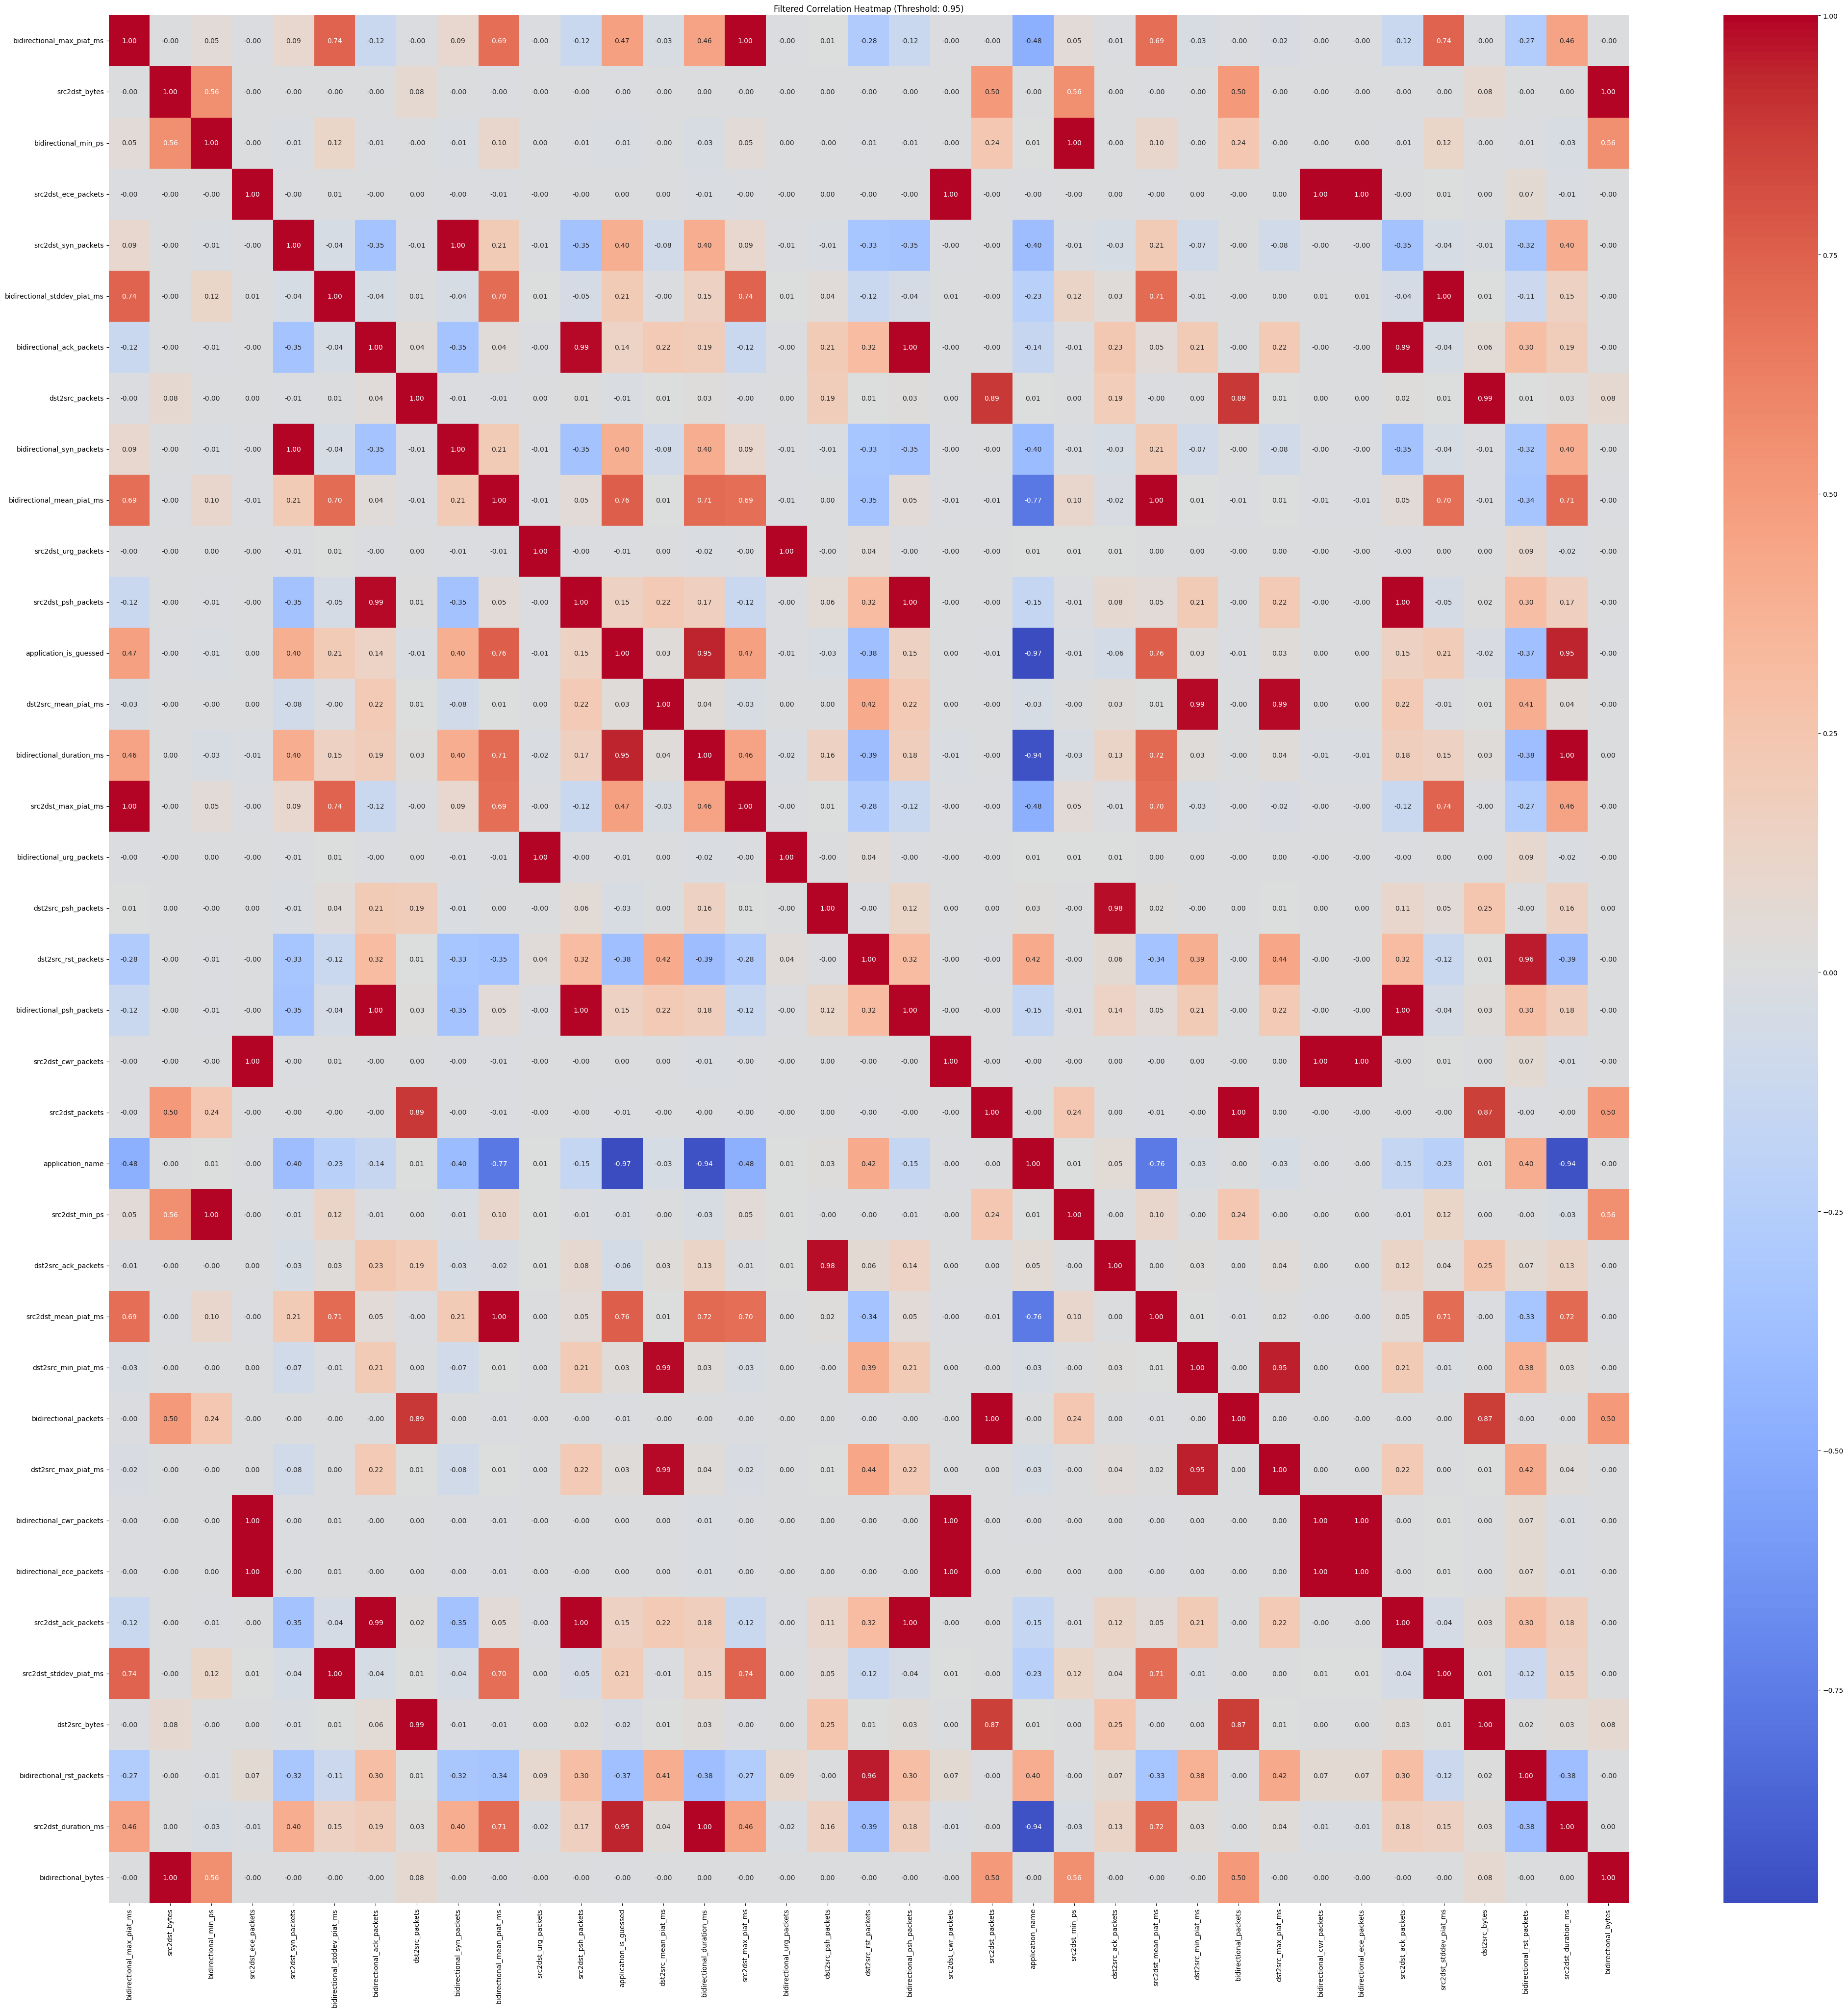

Features to keep: {'bidirectional_cwr_packets', 'bidirectional_max_piat_ms', 'bidirectional_mean_piat_ms', 'bidirectional_min_ps', 'dst2src_mean_piat_ms', 'bidirectional_bytes', 'application_name', 'bidirectional_duration_ms', 'dst2src_ack_packets', 'bidirectional_stddev_piat_ms', 'bidirectional_ack_packets', 'bidirectional_rst_packets', 'dst2src_packets', 'bidirectional_packets', 'bidirectional_syn_packets', 'bidirectional_urg_packets'}
Features to remove: {'src2dst_bytes', 'src2dst_ece_packets', 'src2dst_syn_packets', 'src2dst_urg_packets', 'src2dst_psh_packets', 'application_is_guessed', 'src2dst_max_piat_ms', 'dst2src_psh_packets', 'dst2src_rst_packets', 'bidirectional_psh_packets', 'src2dst_cwr_packets', 'src2dst_packets', 'src2dst_min_ps', 'src2dst_mean_piat_ms', 'dst2src_min_piat_ms', 'dst2src_max_piat_ms', 'bidirectional_ece_packets', 'src2dst_ack_packets', 'src2dst_stddev_piat_ms', 'dst2src_bytes', 'src2dst_duration_ms'}


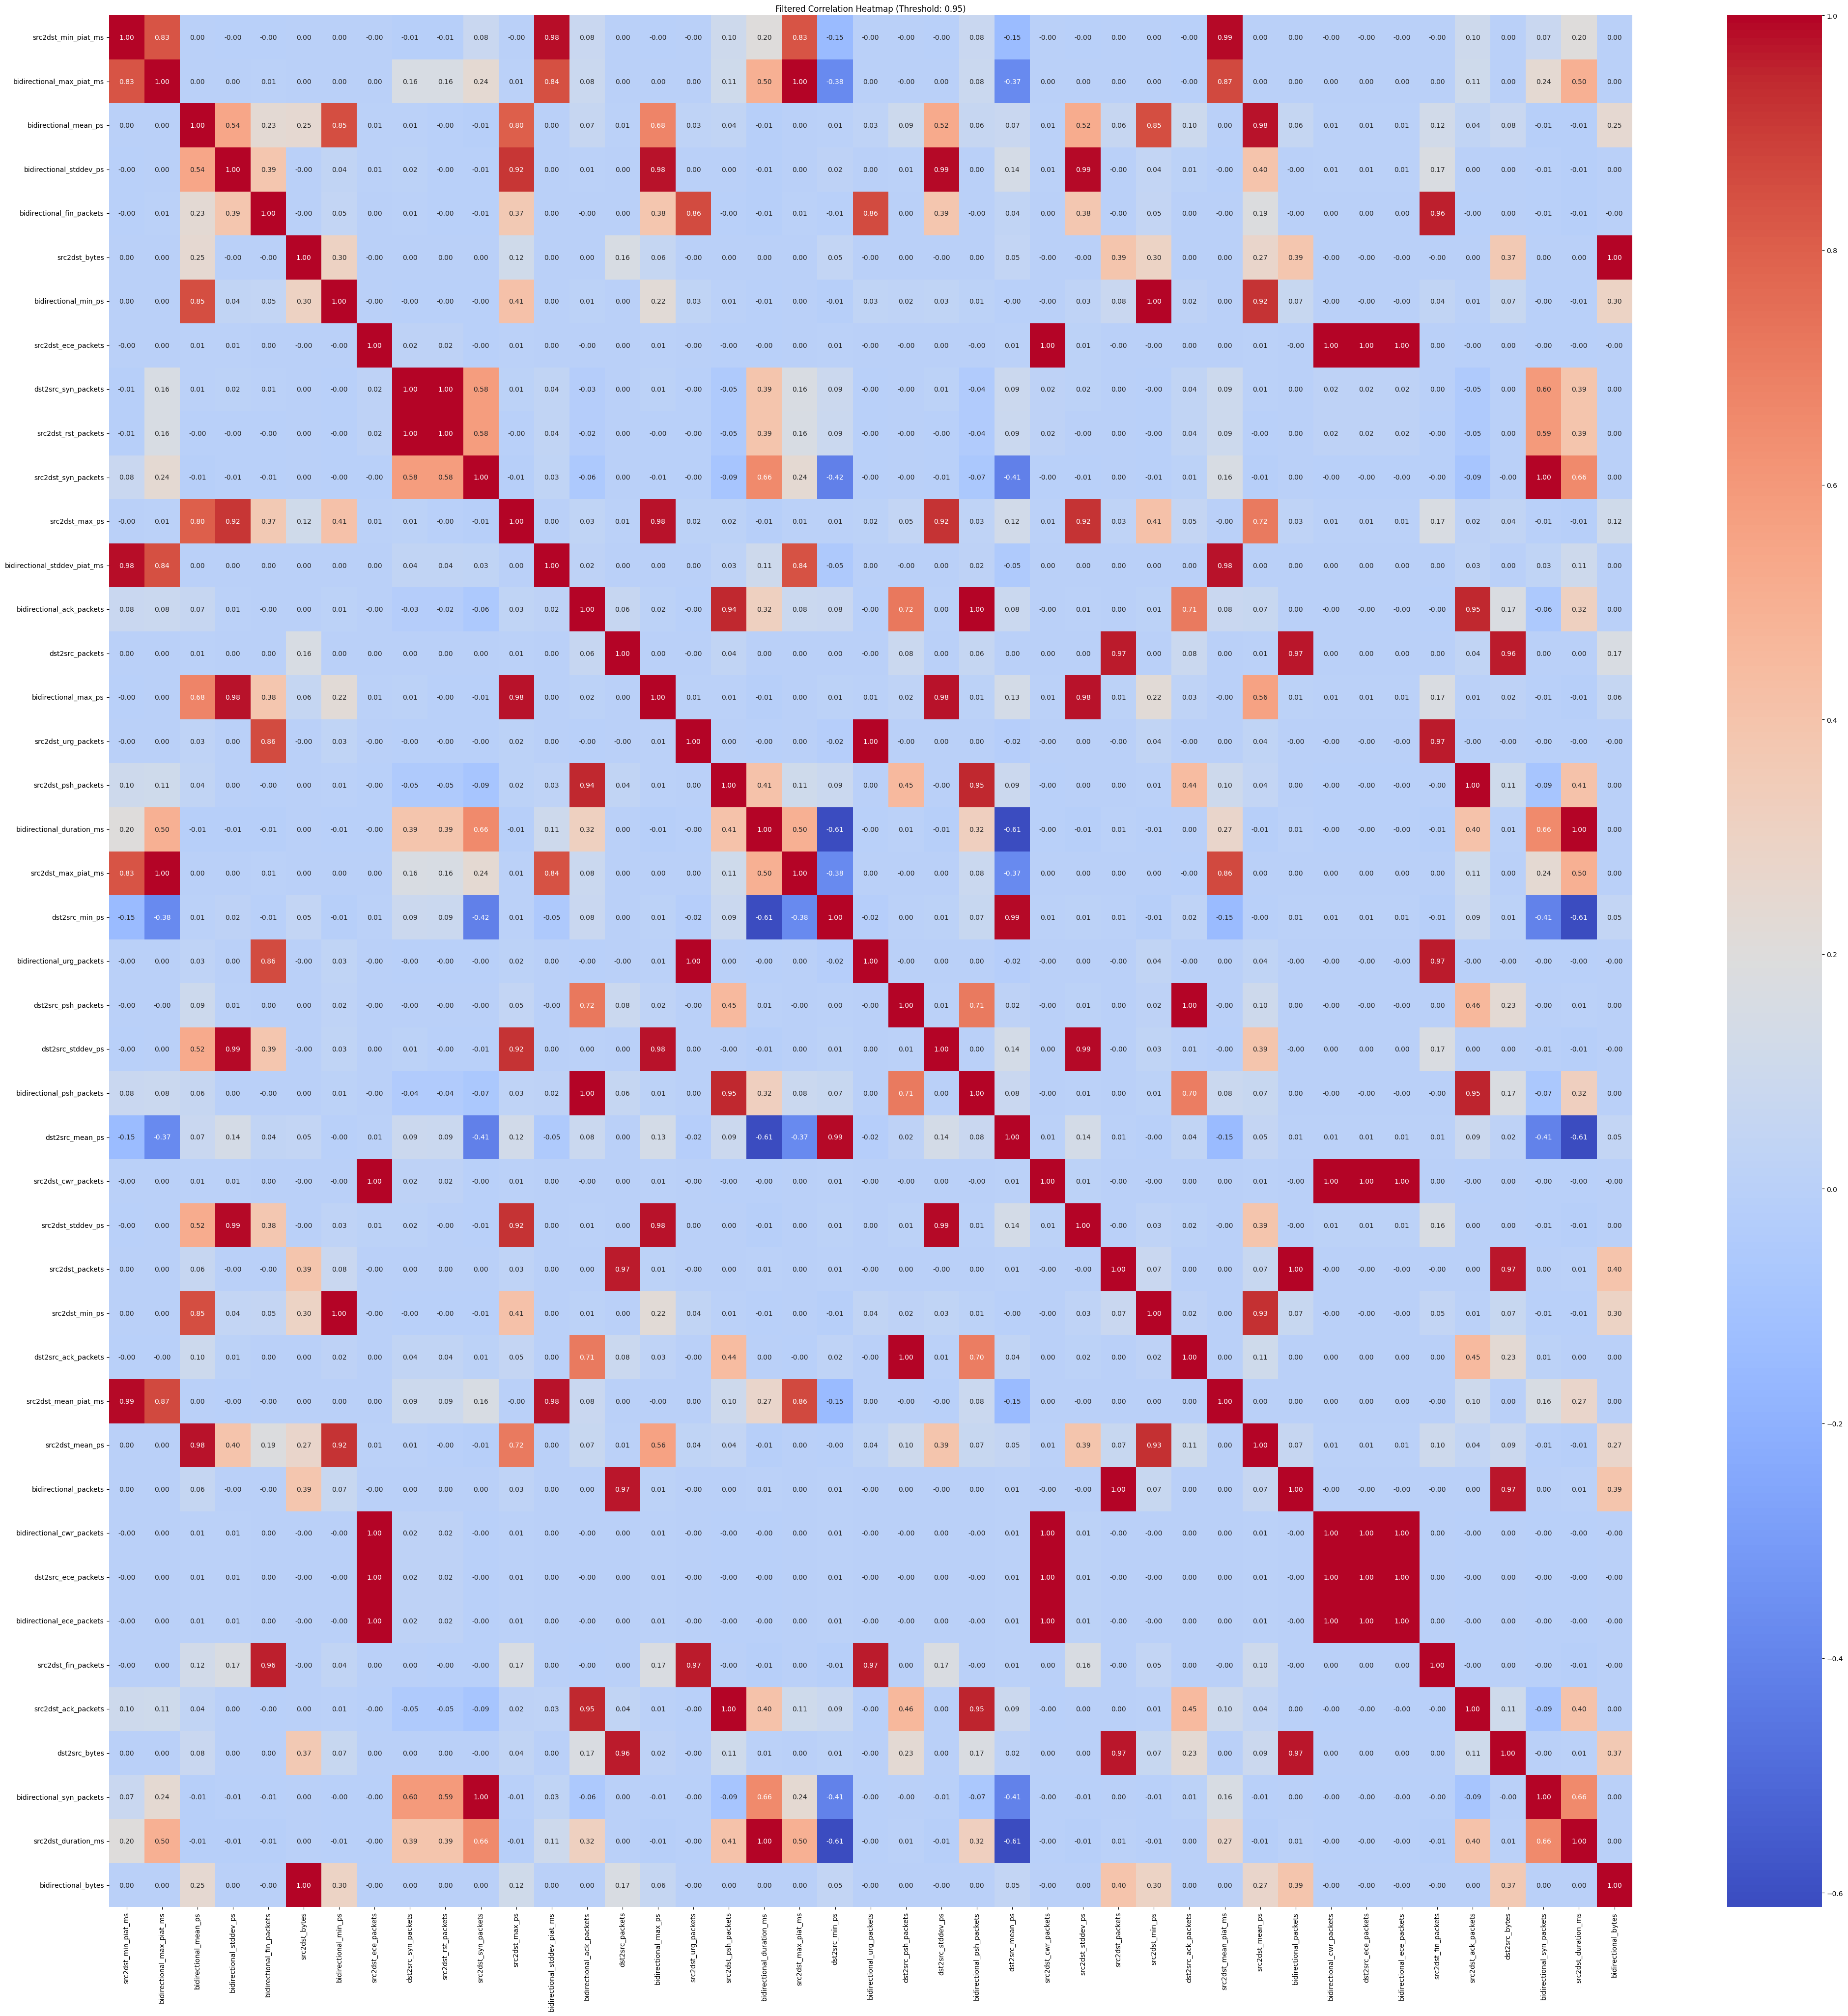

Features to keep: {'bidirectional_cwr_packets', 'bidirectional_max_piat_ms', 'bidirectional_psh_packets', 'src2dst_fin_packets', 'bidirectional_mean_ps', 'src2dst_psh_packets', 'bidirectional_min_ps', 'src2dst_rst_packets', 'src2dst_packets', 'bidirectional_duration_ms', 'dst2src_ack_packets', 'bidirectional_stddev_piat_ms', 'dst2src_min_ps', 'bidirectional_syn_packets', 'bidirectional_max_ps', 'bidirectional_bytes'}
Features to remove: {'src2dst_min_piat_ms', 'bidirectional_stddev_ps', 'bidirectional_fin_packets', 'dst2src_syn_packets', 'src2dst_bytes', 'src2dst_ece_packets', 'src2dst_syn_packets', 'src2dst_max_ps', 'bidirectional_ack_packets', 'dst2src_packets', 'src2dst_urg_packets', 'src2dst_max_piat_ms', 'bidirectional_urg_packets', 'dst2src_psh_packets', 'dst2src_stddev_ps', 'dst2src_mean_ps', 'src2dst_cwr_packets', 'src2dst_stddev_ps', 'src2dst_min_ps', 'src2dst_mean_piat_ms', 'src2dst_mean_ps', 'bidirectional_packets', 'dst2src_ece_packets', 'bidirectional_ece_packets', 'src2ds

In [40]:
features_to_keep_A, features_to_remove_A = getting_uncorrelated_features(df_A)
features_to_keep_B, features_to_remove_B = getting_uncorrelated_features(df_B)


In [41]:
final_features_to_remove = set(features_to_remove_A).intersection(set(features_to_remove_B))

In [42]:
df_A.drop(columns = final_features_to_remove, inplace = True)
df_B.drop(columns = final_features_to_remove, inplace = True)

In [43]:
df_all = pd.concat([df_A, df_B])

In [44]:
set(df_all['CSVNameFile'])

{'Charging-Benign',
 'MaliciousEV-aggressive-scan',
 'MaliciousEV-os-fingerprinting',
 'MaliciousEV-port-scan',
 'MaliciousEV-service-detection',
 'MaliciousEV-syn-stealth-scan',
 'MaliciousEV-vulnerability-scan',
 'charging-Aggressive-scan',
 'charging-aggressive-scan',
 'charging-icmp-flood',
 'charging-icmp-fragmentation',
 'charging-os-fingerprinting',
 'charging-port-scan',
 'charging-portscan',
 'charging-push-ack-flood',
 'charging-service-detection',
 'charging-service-detection-scan',
 'charging-slowLoris-scan',
 'charging-syn-flood',
 'charging-syn-stealth',
 'charging-synonymous-ip',
 'charging-synonymous-ip-flood',
 'charging-tcp-flood',
 'charging-udp-flood',
 'charging-vulnerability-scan',
 'idle-aggressive-scan',
 'idle-benign',
 'idle-icmp-flood',
 'idle-icmp-fragmentation',
 'idle-os-fingerprinting',
 'idle-port-scan',
 'idle-portscan',
 'idle-push-ack-flood',
 'idle-service-detection',
 'idle-slowloris-scan',
 'idle-syn-flood',
 'idle-syn-stealth-scan',
 'idle-synonym

In [45]:
# Define the mapping of current labels to final labels
# Label mapping
label_mapping = {
    "Benign": [
        "Charging-Benign", "idle-benign"
    ],
    "Recon": [
        "MaliciousEV-aggressive-scan", "MaliciousEV-os-fingerprinting", "MaliciousEV-port-scan",
        "MaliciousEV-service-detection", "MaliciousEV-syn-stealth-scan", "MaliciousEV-vulnerability-scan",
        "charging-Aggressive-scan", "charging-aggressive-scan", "charging-os-fingerprinting", 
        "charging-port-scan", "charging-portscan", "charging-service-detection", 
        "charging-service-detection-scan", "charging-syn-stealth", "charging-vulnerability-scan",
        "idle-aggressive-scan", "idle-os-fingerprinting", "idle-port-scan", "idle-portscan",
        "idle-service-detection", "idle-syn-stealth-scan", "idle-vulnerability-scan"
    ],
    "DoS": [
        "charging-icmp-flood", "charging-icmp-fragmentation", "charging-push-ack-flood",
        "charging-slowLoris-scan", "charging-syn-flood", "charging-synonymous-ip",
        "charging-synonymous-ip-flood", "charging-tcp-flood", "charging-udp-flood",
        "idle-icmp-flood", "idle-icmp-fragmentation", "idle-push-ack-flood", "idle-slowloris-scan",
        "idle-syn-flood", "idle-synonymous-ip", "idle-synonymous-ip-flood", "idle-tcp-flood",
        "idle-udp-flood"
    ]
}

# Reverse the mapping to easily lookup categories by label
reverse_mapping = {}
for category, labels in label_mapping.items():
    for label in labels:
        reverse_mapping[label] = category
        
# Map the labels to the new column
df_A['multiclass'] = df_A['CSVNameFile'].map(reverse_mapping)
df_B['multiclass'] = df_B['CSVNameFile'].map(reverse_mapping)

In [46]:
print(df_A['multiclass'].value_counts() )
print(df_B['multiclass'].value_counts() )

multiclass
DoS       478998
Recon      68774
Benign        82
Name: count, dtype: int64
multiclass
Recon    1655849
DoS       540997
Name: count, dtype: int64


In [47]:
# Check if multiclass is benign it really is in CSVFIle names

# Filter the DataFrame for rows where 'status' is 'benign'
bening_rows = df_A[df_A['status'] == 'Benign']

# Display the 'CSVNameFile' values for these rows
set(bening_rows['CSVNameFile'])

{'Charging-Benign',
 'charging-Aggressive-scan',
 'charging-icmp-flood',
 'charging-icmp-fragmentation',
 'charging-os-fingerprinting',
 'charging-portscan',
 'charging-service-detection',
 'charging-slowLoris-scan',
 'charging-syn-flood',
 'charging-syn-stealth',
 'charging-synonymous-ip',
 'charging-tcp-flood',
 'charging-udp-flood',
 'charging-vulnerability-scan',
 'idle-aggressive-scan',
 'idle-benign',
 'idle-icmp-fragmentation',
 'idle-os-fingerprinting',
 'idle-portscan',
 'idle-service-detection',
 'idle-slowloris-scan',
 'idle-syn-flood',
 'idle-syn-stealth-scan',
 'idle-synonymous-ip',
 'idle-tcp-flood',
 'idle-udp-flood',
 'idle-vulnerability-scan'}

In [48]:
# There might be benign traffic in the files even if the file names don't mention it.
# The correct way is to use the mac address

def benign_traffic(df):
    # Update 'multiclass' column based on the 'status' column
    df.loc[df['status'] == 'Benign', 'multiclass'] = 'Benign'
    return df

df_A = benign_traffic(df_A)
df_B = benign_traffic(df_B)

In [49]:
print(df_A['multiclass'].value_counts() )
print(df_B['multiclass'].value_counts() )

multiclass
DoS       462954
Recon      68745
Benign     16155
Name: count, dtype: int64
multiclass
Recon     1090985
Benign     581518
DoS        524343
Name: count, dtype: int64


In [70]:
# Distributions
def distribution(column, name):
    multiclass_distribution = column.value_counts()

    plt.figure(figsize=(14, 8))
    bars = multiclass_distribution.plot(kind='bar')
    plt.title('Distribution of multi-class Labels')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

    # Adding percentages on top of each bar
    total = multiclass_distribution.sum()
    for bar in bars.patches:
        percentage = f'{(bar.get_height() / total) * 100:.2f}%'
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            percentage, 
            ha='center', 
            color='black', 
            weight='bold'
        )

    plt.tight_layout()
    # Save the current figure to a PDF file
    plt.savefig(name +'.pdf', format='pdf')
    plt.show()
    
    print(column.value_counts())

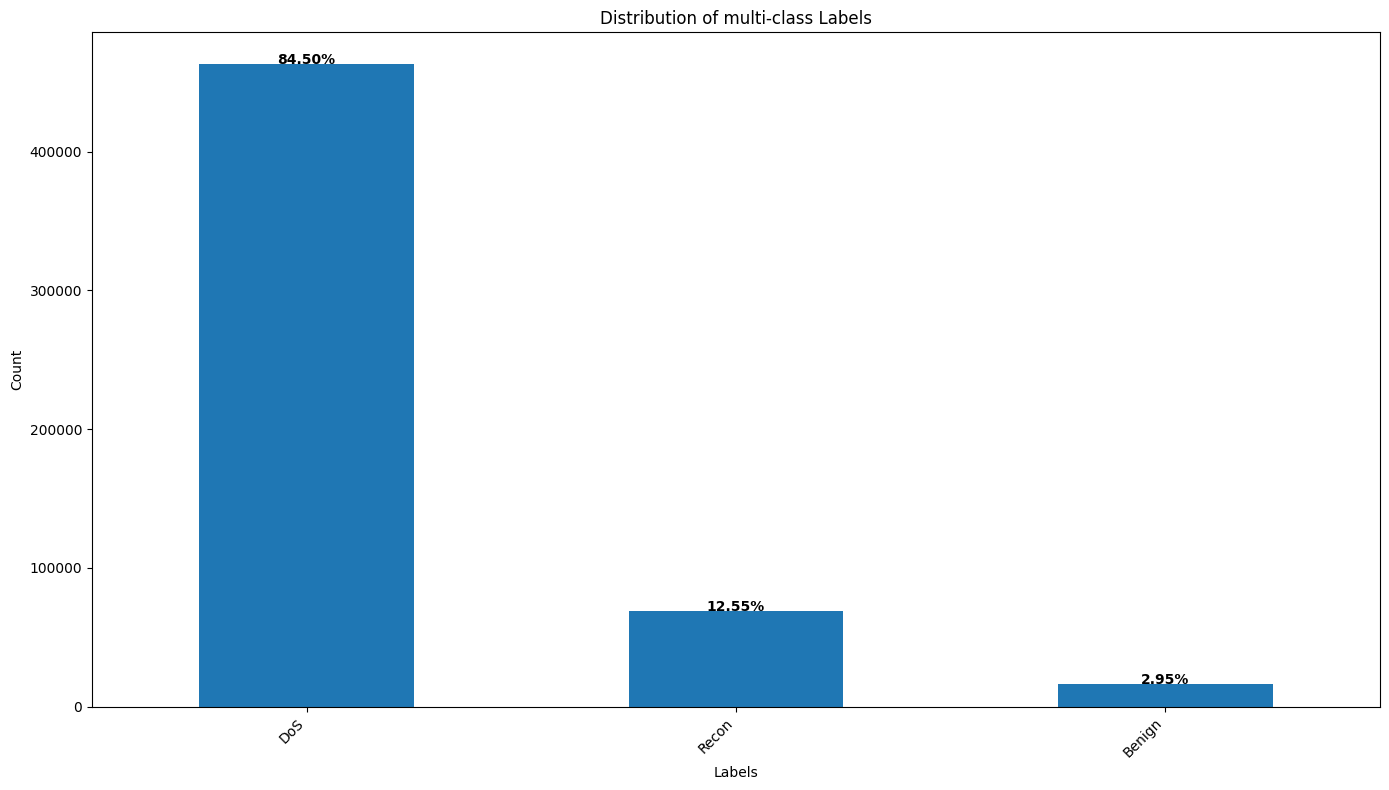

multiclass
DoS       462954
Recon      68745
Benign     16155
Name: count, dtype: int64


In [71]:
distribution(df_A['multiclass'], 'output_distribution_A')

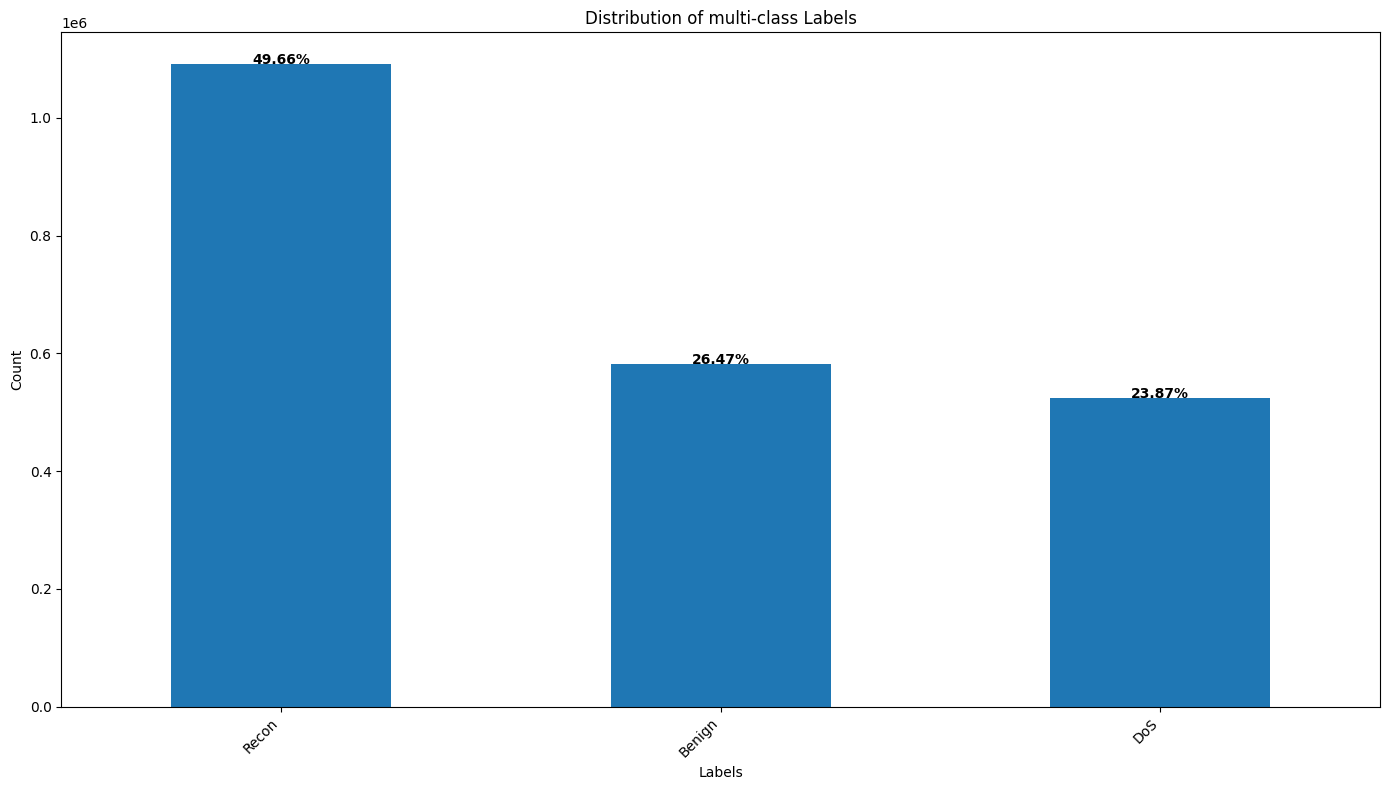

multiclass
Recon     1090985
Benign     581518
DoS        524343
Name: count, dtype: int64


In [81]:
distribution(df_B['multiclass'], 'output_distribution_B')

In [55]:
# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(df_B['multiclass']),
                                                  y=df_B['multiclass'])

class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Print class weights
print("Class weights:", class_weights_dict)

Class weights: {0: 1.2592593866397945, 1: 1.396570565450478, 2: 0.671211794845942}


In [56]:
df_A.columns

Index(['src_port', 'dst_port', 'protocol', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_packets',
       'dst2src_duration_ms', 'dst2src_packets', 'bidirectional_min_ps',
       'bidirectional_mean_ps', 'bidirectional_stddev_ps',
       'bidirectional_max_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps',
       'src2dst_max_ps', 'dst2src_min_ps', 'dst2src_mean_ps',
       'dst2src_stddev_ps', 'dst2src_max_ps', 'bidirectional_min_piat_ms',
       'bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms',
       'src2dst_stddev_piat_ms', 'dst2src_min_piat_ms', 'dst2src_mean_piat_ms',
       'dst2src_stddev_piat_ms', 'dst2src_max_piat_ms',
       'bidirectional_syn_packets', 'bidirectional_cwr_packets',
       'bidirectional_urg_packets', 'bidirectional_ack_packets',
       'bidirectional_psh_packets', 'bidirectional_rst_packets',
       'bidirectional_fin_packets', 'src2dst_psh_packet

In [76]:
df_A.to_csv('Final_EVSE_A.csv', index=False)
df_B.to_csv('Final_EVSE_B.csv', index=False)

In [82]:
df_A.columns

Index(['src_port', 'dst_port', 'protocol', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_packets',
       'dst2src_duration_ms', 'dst2src_packets', 'bidirectional_min_ps',
       'bidirectional_mean_ps', 'bidirectional_stddev_ps',
       'bidirectional_max_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps',
       'src2dst_max_ps', 'dst2src_min_ps', 'dst2src_mean_ps',
       'dst2src_stddev_ps', 'dst2src_max_ps', 'bidirectional_min_piat_ms',
       'bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms',
       'src2dst_stddev_piat_ms', 'dst2src_min_piat_ms', 'dst2src_mean_piat_ms',
       'dst2src_stddev_piat_ms', 'dst2src_max_piat_ms',
       'bidirectional_syn_packets', 'bidirectional_cwr_packets',
       'bidirectional_urg_packets', 'bidirectional_ack_packets',
       'bidirectional_psh_packets', 'bidirectional_rst_packets',
       'bidirectional_fin_packets', 'src2dst_psh_packet

In [3]:
len(df_A.columns)

52

In [ ]:
# Training

In [2]:
df_A = pd.read_csv('Final_EVSE_A.csv')
df_B = pd.read_csv('Final_EVSE_B.csv')

In [3]:
def prepare_categorical_output(y):
    # # Print the `y` matrix before encoding
    # print("y matrix before encoding:\n", y)

    # Convert Series to NumPy array and reshape `y` matrix
    y = y.values.reshape(-1, 1)

    # Print the `y` matrix after reshaping
    # print("y matrix after reshaping:\n", y)
    
    # One-hot encode the target variable
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(y)

    # Print the `y` matrix after one-hot encoding
    # print("y matrix after one-hot encoding:\n", y)
    
    return y

In [4]:
#Considering B charging station as training and A as testing

In [5]:
def assigning_set(df1, df2):
    # Group by 'CSVNameFile' and split the last 20% of each group into the validation set
    train_list = []
    val_list = []

    grouped = df1.groupby('CSVNameFile')

    for _, group in grouped:
        split_index = int(len(group) * 0.8)
        train_list.append(group.iloc[:split_index])
        val_list.append(group.iloc[split_index:])

    # Concatenate the training and validation sets
    train_df = pd.concat(train_list).reset_index(drop=True)
    val_df = pd.concat(val_list).reset_index(drop=True)

    # Separate features and labels for train and validation sets
    X_train = train_df.drop(columns=['CSVNameFile', 'status', 'multiclass'])
    y_train = prepare_categorical_output(train_df['multiclass'])

    X_val = val_df.drop(columns=['CSVNameFile', 'status', 'multiclass'])
    y_val = prepare_categorical_output(val_df['multiclass'])

    # X_test and y_test from df2 remain unchanged for test evaluation
    X_test = df2.drop(columns=['CSVNameFile', 'status', 'multiclass'])
    y_test = prepare_categorical_output(df2['multiclass'])

    input_dim = X_train.shape[1]
    output_dim = len(np.unique(df1['multiclass']))

    return X_train, X_val, X_test, y_train, y_val, y_test, input_dim, output_dim

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test, input_dim, output_dim = assigning_set(df_B, df_A)

In [25]:
def create_MLP_HPO(X_train, X_val, X_test, y_train, y_val, y_test, input_dim, output_dim, df_name):    

    def create_model(neurons=[16, 16]):
        model = Sequential()
        model.add(Input(shape=(input_dim,)))

        # Add layers based on the number of neurons specified
        for neuron_count in neurons:
            model.add(Dense(neuron_count, activation='relu'))

        # Output layer
        model.add(Dense(output_dim, activation='softmax'))  
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def objective(trial):  # This is the Optuna objective function
        # Suggest the number of layers and neurons per layer
        num_layers = trial.suggest_int('num_layers', 1, 8)
        neurons = [trial.suggest_categorical(f'neurons_layer_{i}', [16, 32, 64, 128]) for i in range(num_layers)]
        
        # Create the model
        model = create_model(neurons=neurons)

        # Train the model 
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        tf_keras_pruning_callback = TFKerasPruningCallback(trial, 'val_loss')
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            callbacks=[early_stopping, tf_keras_pruning_callback],
                            batch_size=32, epochs=50, verbose=1) 
        
        # Get the best validation accuracy during training
        val_accuracy = max(history.history['val_accuracy'])
        return val_accuracy
    
    def print_trial_callback(study, trial):
        print(f"Trial {trial.number} finished with value: {trial.value}")
        print(f"    Params: {trial.params}")
        print(f"    Best trial so far: {study.best_trial.number}, Value: {study.best_trial.value}")
        
    # Optimize hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10, n_jobs=-1, callbacks=[print_trial_callback])

    # Save the trial results into a DataFrame
    results = study.trials_dataframe()
    print(results)
    results.to_csv(f'{df_name}_optuna_results.csv', index=False)

    # Print the best parameters found
    print("Best parameters found: ", study.best_trial.params)

    # Get the best hyperparameters and train the final model
    best_trial = study.best_trial
    best_model = create_model([best_trial.params[f'neurons_layer_{i}'] for i in range(best_trial.params['num_layers'])])

    # Train the best model with fixed batch size
    best_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                   batch_size=32, epochs=50, verbose=1)

    # Evaluate the best model on the test data
    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Accuracy: {accuracy:.4f}')

    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')

    # Save the best model
    best_model.save(f'{df_name}.keras')  # Save in Keras format
    best_model.save(f'{df_name}.h5')  # Save as .h5
    best_model.save_weights(f'{df_name}.weights.h5')  # Save weights separately

    return best_model


In [27]:
model1 = create_MLP_HPO(X_train, X_val, X_test, y_train, y_val, y_test, input_dim, output_dim, 'MLP_HPO')

[I 2024-09-16 16:03:26,016] A new study created in memory with name: no-name-b072d9a7-1d37-46eb-a92e-548ad8b3f990


Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 8905s 162ms/step - accuracy: 0.7591 - loss: 78.6009 - val_accuracy: 0.7351 - val_loss: 0.5004
32051/54921 ━━━━━━━━━━━━━━━━━━━━ 1:45:43 277ms/step - accuracy: 0.7152 - loss: 1445.5806Epoch 2/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 11586s 211ms/step - accuracy: 0.7197 - loss: 125.3335 - val_accuracy: 0.7426 - val_loss: 0.4843
38347/54921 ━━━━━━━━━━━━━━━━━━━━ 1:23:15 301ms/step - accuracy: 0.7196 - loss: 434.0112Epoch 2/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 12612s 229ms/step - accuracy: 0.7158 - loss: 475.9908 - val_accuracy: 0.7426 - val_loss: 0.6644
47065/54921 ━━━━━━━━━━━━━━━━━━━━ 35:01 267ms/step - accuracy: 0.6806 - loss: 2.9290Epoch 2/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 14284s 260ms/step - accuracy: 0.8111 - loss: 935.8883 - val_accuracy: 0.9284 - val_loss: 0.2020
13477/54921 ━━━━━━━━━━━━━━━━━━━━ 2:18:15 200ms/step - accuracy: 0.6099 - loss: 115.12

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



54921/54921 ━━━━━━━━━━━━━━━━━━━━ 14544s 265ms/step - accuracy: 0.4960 - loss: 1.0420 - val_accuracy: 0.4966 - val_loss: 1.0416
40615/54921 ━━━━━━━━━━━━━━━━━━━━ 46:23 195ms/step - accuracy: 0.4970 - loss: 1.04123

[I 2024-09-17 20:44:44,954] Trial 1 finished with value: 0.7349777817726135 and parameters: {'num_layers': 5, 'neurons_layer_0': 64, 'neurons_layer_1': 128, 'neurons_layer_2': 32, 'neurons_layer_3': 64, 'neurons_layer_4': 128}. Best is trial 8 with value: 0.7426885962486267.


Trial 1 finished with value: 0.7349777817726135
    Params: {'num_layers': 5, 'neurons_layer_0': 64, 'neurons_layer_1': 128, 'neurons_layer_2': 32, 'neurons_layer_3': 64, 'neurons_layer_4': 128}
    Best trial so far: 8, Value: 0.7426885962486267
18727/54921 ━━━━━━━━━━━━━━━━━━━━ 2:01:49 202ms/step - accuracy: 0.4945 - loss: 1.0430

[I 2024-09-17 21:33:16,944] Trial 0 pruned. Trial was pruned at epoch 7.


Trial 0 finished with value: 0.18216359615325928
    Params: {'num_layers': 2, 'neurons_layer_0': 128, 'neurons_layer_1': 128}
    Best trial so far: 8, Value: 0.7426885962486267
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 10936s 199ms/step - accuracy: 0.4969 - loss: 1.0412 - val_accuracy: 0.4966 - val_loss: 1.0417
Epoch 8/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 9541s 174ms/step - accuracy: 0.4969 - loss: 1.0413 - val_accuracy: 0.4966 - val_loss: 1.0416
Epoch 8/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 5366s 98ms/step - accuracy: 0.4968 - loss: 1.0413 - val_accuracy: 0.4966 - val_loss: 1.0415
Epoch 9/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 4106s 75ms/step - accuracy: 0.4963 - loss: 1.0417 - val_accuracy: 0.4966 - val_loss: 1.0413
Epoch 9/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 3791s 69ms/step - accuracy: 0.4968 - loss: 1.0413 - val_accuracy: 0.4966 - val_loss: 1.0415
Epoch 10/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 3837s 70ms/step - accuracy: 0.4967 - loss: 1.0414 - val_accuracy: 0.4966 - val_loss: 1.0415
Epoch 11/50


[I 2024-09-18 06:22:39,117] Trial 3 finished with value: 0.4966202676296234 and parameters: {'num_layers': 6, 'neurons_layer_0': 32, 'neurons_layer_1': 64, 'neurons_layer_2': 64, 'neurons_layer_3': 64, 'neurons_layer_4': 16, 'neurons_layer_5': 32}. Best is trial 8 with value: 0.7426885962486267.


Trial 3 finished with value: 0.4966202676296234
    Params: {'num_layers': 6, 'neurons_layer_0': 32, 'neurons_layer_1': 64, 'neurons_layer_2': 64, 'neurons_layer_3': 64, 'neurons_layer_4': 16, 'neurons_layer_5': 32}
    Best trial so far: 8, Value: 0.7426885962486267
   number     value             datetime_start          datetime_complete  \
0       0  0.182164 2024-09-16 16:03:26.036652 2024-09-17 21:33:16.944580   
1       1  0.734978 2024-09-16 16:03:26.041676 2024-09-17 20:44:44.954927   
2       2  0.496620 2024-09-16 16:03:26.043653 2024-09-18 05:52:00.196931   
3       3  0.496620 2024-09-16 16:03:26.048615 2024-09-18 06:22:39.117912   
4       4  0.496620 2024-09-16 16:03:26.052613 2024-09-18 04:05:46.125136   
5       5  0.742666 2024-09-16 16:03:26.052613 2024-09-17 19:29:22.994483   
6       6  0.742645 2024-09-16 16:03:26.053612 2024-09-17 11:23:10.846551   
7       7  0.492466 2024-09-16 16:03:26.062615 2024-09-17 22:52:06.190428   
8       8  0.742689 2024-09-16 16:03:26

Test Accuracy: 0.9821
Test Precision: 0.9846
Test Recall: 0.9821
Test F1 Score: 0.9828


In [22]:
def create_LSTM_HPO(X_train, X_val, X_test, y_train, y_val, y_test, input_dim, output_dim, df_name, timesteps):
    
    def create_sequences(X, y, timesteps):
        X_seq, y_seq = [], []
        X = X.values  # Convert DataFrame to Numpy array
        for i in range(len(X) - timesteps):
            X_seq.append(X[i:i + timesteps])
            y_seq.append(y[i + timesteps - 1])
        return np.array(X_seq), np.array(y_seq)

    # Generate sequences for training, validation, and testing using the sliding window approach
    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)
    print(X_test.shape, y_test.shape)
    X_train, y_train = create_sequences(X_train, y_train, timesteps)
    X_val, y_val = create_sequences(X_val, y_val, timesteps)
    X_test, y_test = create_sequences(X_test, y_test, timesteps)
    
    print('After using create_sequence')
    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)
    print(X_test.shape, y_test.shape)

    def create_model(units):
        # Fixed hyperparameters
        optimizer = 'adam'
        
        model = Sequential()
        model.add(Input(shape=(timesteps, input_dim)))

        # Add LSTM layers
        for i, unit_count in enumerate(units):
            return_sequences = i < len(units) - 1  # Set return_sequences=True for all but the last LSTM layer
            model.add(LSTM(unit_count, return_sequences=return_sequences))

        model.add(Dense(output_dim, activation='softmax'))  # Output layer
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def objective(trial):  # This objective function is what Optuna will try to optimize.
        # Suggest the number of layers and units per layer
        num_layers = trial.suggest_int('num_layers', 1, 3)
        units = [trial.suggest_int(f'units_layer_{i}', 50, 100, step=25) for i in range(num_layers)]
        
        # Create the model using the fixed hyperparameters and the suggested layer configuration
        model = create_model(units)

        # Train the model with pruning callback and early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        tf_keras_pruning_callback = TFKerasPruningCallback(trial, 'val_loss')
        
        print(f"Training model with {num_layers} layers and units: {units}")

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            callbacks=[early_stopping, tf_keras_pruning_callback], 
                            batch_size=32, 
                            epochs=50, verbose=1)
        
        # Get the best validation accuracy during training
        val_accuracy = max(history.history['val_accuracy'])
        return val_accuracy

    def print_trial_callback(study, trial):
        print(f"Trial {trial.number} finished with value: {trial.value}")
        print(f"    Params: {trial.params}")
        print(f"    Best trial so far: {study.best_trial.number}, Value: {study.best_trial.value}")

    # Optimize hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    # study.optimize(objective, n_trials=10, n_jobs=-1, callbacks=[print_trial_callback])
    study.optimize(objective, n_trials=10, n_jobs=8, callbacks=[print_trial_callback])

    # Save the trial results into a DataFrame
    results = study.trials_dataframe()
    print(results)
    results.to_csv(f'{df_name}_optuna_results.csv', index=False)

    # Print the best parameters found
    print("Best parameters found: ", study.best_trial.params)

    # Get the best hyperparameters and train the final model
    best_trial = study.best_trial
    best_model = create_model([best_trial.params[f'units_layer_{i}'] for i in range(best_trial.params['num_layers'])])

    best_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                   batch_size=32, epochs=50, verbose=1)

    # Evaluate the best model on the test data
    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Accuracy (from evaluate): {accuracy:.4f}')

    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    
    print(f'Test Accuracy (from sklearn): {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')

    # Save the best model in multiple formats
    model_path = f'{df_name}'
    best_model.save(f'{model_path}.keras')  # Save as keras
    best_model.save(f'{model_path}.h5')  # Save as .h5
    best_model.save_weights(f'{model_path}.weights.h5')  # Save weights separately

    return best_model


In [24]:
model2 = create_LSTM_HPO(X_train, X_val, X_test, y_train, y_val, y_test, input_dim, output_dim, 'LSTM_HPO', 5)

(1757464, 49) (1757464, 3)
(439382, 49) (439382, 3)
(547854, 49) (547854, 3)


[I 2024-09-13 11:07:19,533] A new study created in memory with name: no-name-7cfc7180-994f-4aab-94cf-40bbeab58f19


After using create_sequence
(1757459, 5, 49) (1757459, 3)
(439377, 5, 49) (439377, 3)
(547849, 5, 49) (547849, 3)
Training model with 1 layers and units: [100]
Training model with 1 layers and units: [100]
Training model with 1 layers and units: [50]
Training model with 1 layers and units: [75]
Training model with 1 layers and units: [50]
Training model with 2 layers and units: [75, 50]
Training model with 2 layers and units: [75, 75]
Training model with 3 layers and units: [75, 50, 75]
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 365s 6ms/step - accuracy: 0.7412 - loss: 0.4909 - val_accuracy: 0.7429 - val_loss: 0.4850
Epoch 2/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 365s 6ms/step - accuracy: 0.7418 - loss: 0.4924 - val_accuracy: 0.7429 - val_loss: 0.4847
34127/54921 ━━━━━━━━━━━━━━━━━━━━ 3:25 10ms/step - accuracy: 0.7426 - loss: 0.4867Epoch 2/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 375s 7ms/step - accuracy: 0.7427 - los

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



54921/54921 ━━━━━━━━━━━━━━━━━━━━ 2134s 39ms/step - accuracy: 0.7431 - loss: 0.4845 - val_accuracy: 0.7430 - val_loss: 0.4841
Epoch 6/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 2147s 39ms/step - accuracy: 0.7436 - loss: 0.4836 - val_accuracy: 0.7429 - val_loss: 0.4856
Epoch 6/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 2713s 49ms/step - accuracy: 0.7438 - loss: 0.4833 - val_accuracy: 0.7429 - val_loss: 0.4841
Epoch 7/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 2727s 50ms/step - accuracy: 0.7435 - loss: 0.4833 - val_accuracy: 0.7430 - val_loss: 0.4841
Epoch 7/50
42316/54921 ━━━━━━━━━━━━━━━━━━━━ 15:46 75ms/step - accuracy: 0.7436 - loss: 0.4837

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 5374/54921 ━━━━━━━━━━━━━━━━━━━━ 1:17:01 93ms/step - accuracy: 0.7447 - loss: 0.4835

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 6603/54921 ━━━━━━━━━━━━━━━━━━━━ 1:15:00 93ms/step - accuracy: 0.7448 - loss: 0.4823

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



48372/54921 ━━━━━━━━━━━━━━━━━━━━ 8:21 77ms/step - accuracy: 0.7438 - loss: 0.4827

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



10022/54921 ━━━━━━━━━━━━━━━━━━━━ 1:09:45 93ms/step - accuracy: 0.7445 - loss: 0.4826

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



12188/54921 ━━━━━━━━━━━━━━━━━━━━ 1:06:45 94ms/step - accuracy: 0.7444 - loss: 0.4827

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



13703/54921 ━━━━━━━━━━━━━━━━━━━━ 1:04:42 94ms/step - accuracy: 0.7444 - loss: 0.4827

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



16689/54921 ━━━━━━━━━━━━━━━━━━━━ 59:02 93ms/step - accuracy: 0.7448 - loss: 0.48328

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



54921/54921 ━━━━━━━━━━━━━━━━━━━━ 4802s 87ms/step - accuracy: 0.7436 - loss: 0.4837 - val_accuracy: 0.7429 - val_loss: 0.4841
Epoch 8/50
  656/54921 ━━━━━━━━━━━━━━━━━━━━ 1:26:17 95ms/step - accuracy: 0.7477 - loss: 0.4793 0.48

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 2371/54921 ━━━━━━━━━━━━━━━━━━━━ 1:25:05 97ms/step - accuracy: 0.7436 - loss: 0.4835 0.483

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



54921/54921 ━━━━━━━━━━━━━━━━━━━━ 9148s 167ms/step - accuracy: 0.7439 - loss: 0.4827 - val_accuracy: 0.7429 - val_loss: 0.4851
Epoch 4/50
 1315/54921 ━━━━━━━━━━━━━━━━━━━━ 3:06:05 208ms/step - accuracy: 0.7426 - loss: 0.4853: 0.482

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



26118/54921 ━━━━━━━━━━━━━━━━━━━━ 46:13 96ms/step - accuracy: 0.7441 - loss: 0.4829

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 7590/54921 ━━━━━━━━━━━━━━━━━━━━ 1:25:19 108ms/step - accuracy: 0.7430 - loss: 0.4835

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



44586/54921 ━━━━━━━━━━━━━━━━━━━━ 16:21 95ms/step - accuracy: 0.7440 - loss: 0.48338

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



11434/54921 ━━━━━━━━━━━━━━━━━━━━ 1:19:54 110ms/step - accuracy: 0.7448 - loss: 0.4827

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 5338/54921 ━━━━━━━━━━━━━━━━━━━━ 3:08:54 229ms/step - accuracy: 0.7430 - loss: 0.4837

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



49179/54921 ━━━━━━━━━━━━━━━━━━━━ 9:25 98ms/step - accuracy: 0.7440 - loss: 0.4834482

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



15139/54921 ━━━━━━━━━━━━━━━━━━━━ 1:16:39 116ms/step - accuracy: 0.7433 - loss: 0.4832

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



17393/54921 ━━━━━━━━━━━━━━━━━━━━ 1:12:11 115ms/step - accuracy: 0.7445 - loss: 0.4829

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 8468/54921 ━━━━━━━━━━━━━━━━━━━━ 3:02:58 236ms/step - accuracy: 0.7427 - loss: 0.4838

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



19938/54921 ━━━━━━━━━━━━━━━━━━━━ 1:09:12 119ms/step - accuracy: 0.7434 - loss: 0.4831

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



54921/54921 ━━━━━━━━━━━━━━━━━━━━ 6642s 121ms/step - accuracy: 0.7439 - loss: 0.4834 - val_accuracy: 0.7430 - val_loss: 0.4858
Epoch 8/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 7524s 137ms/step - accuracy: 0.7441 - loss: 0.4838 - val_accuracy: 0.7430 - val_loss: 0.4843
Epoch 8/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 7570s 138ms/step - accuracy: 0.7440 - loss: 0.4831 - val_accuracy: 0.7429 - val_loss: 0.4845
Epoch 8/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 7960s 145ms/step - accuracy: 0.7439 - loss: 0.4834 - val_accuracy: 0.7429 - val_loss: 0.4841
Epoch 9/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 8004s 146ms/step - accuracy: 0.7436 - loss: 0.4830 - val_accuracy: 0.7430 - val_loss: 0.4848
  747/54921 ━━━━━━━━━━━━━━━━━━━━ 2:06:37 140ms/step - accuracy: 0.7447 - loss: 0.4823 0.4843

[I 2024-09-13 16:26:22,462] Trial 4 finished with value: 0.742965579032898 and parameters: {'num_layers': 1, 'units_layer_0': 50}. Best is trial 4 with value: 0.742965579032898.


40620/54921 ━━━━━━━━━━━━━━━━━━━━ 53:59 226ms/step - accuracy: 0.7428 - loss: 0.4843Trial 4 finished with value: 0.742965579032898
    Params: {'num_layers': 1, 'units_layer_0': 50}
    Best trial so far: 4, Value: 0.742965579032898
15751/54921 ━━━━━━━━━━━━━━━━━━━━ 1:37:14 149ms/step - accuracy: 0.7445 - loss: 0.4826Training model with 2 layers and units: [100, 50]
40629/54921 ━━━━━━━━━━━━━━━━━━━━ 53:57 227ms/step - accuracy: 0.7428 - loss: 0.48433Epoch 1/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 10495s 191ms/step - accuracy: 0.7443 - loss: 0.4828 - val_accuracy: 0.7429 - val_loss: 0.4855
 4395/54921 ━━━━━━━━━━━━━━━━━━━━ 4:18:05 306ms/step - accuracy: 0.7457 - loss: 0.4820Epoch 9/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 10226s 186ms/step - accuracy: 0.7432 - loss: 0.4838 - val_accuracy: 0.7429 - val_loss: 0.4842
Epoch 10/50
33934/54921 ━━━━━━━━━━━━━━━━━━━━ 1:49:58 314ms/step - accuracy: 0.7425 - loss: 0.4864

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



41706/54921 ━━━━━━━━━━━━━━━━━━━━ 42:53 195ms/step - accuracy: 0.7434 - loss: 0.48364

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



47948/54921 ━━━━━━━━━━━━━━━━━━━━ 23:11 200ms/step - accuracy: 0.7434 - loss: 0.48362

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



28453/54921 ━━━━━━━━━━━━━━━━━━━━ 1:34:51 215ms/step - accuracy: 0.7432 - loss: 0.4841

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



46632/54921 ━━━━━━━━━━━━━━━━━━━━ 29:52 216ms/step - accuracy: 0.7434 - loss: 0.48393

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



54921/54921 ━━━━━━━━━━━━━━━━━━━━ 13594s 248ms/step - accuracy: 0.7434 - loss: 0.4836 - val_accuracy: 0.7429 - val_loss: 0.4847
Epoch 10/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 22067s 402ms/step - accuracy: 0.7426 - loss: 0.4856 - val_accuracy: 0.7430 - val_loss: 0.4846
Epoch 2/50
 3587/54921 ━━━━━━━━━━━━━━━━━━━━ 2:54:51 204ms/step - accuracy: 0.7433 - loss: 0.4841

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



30738/54921 ━━━━━━━━━━━━━━━━━━━━ 2:42:11 402ms/step - accuracy: 0.7436 - loss: 0.4832

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



54921/54921 ━━━━━━━━━━━━━━━━━━━━ 12719s 232ms/step - accuracy: 0.7434 - loss: 0.4838 - val_accuracy: 0.7429 - val_loss: 0.4840
Epoch 11/50
 8155/54921 ━━━━━━━━━━━━━━━━━━━━ 2:26:17 188ms/step - accuracy: 0.7437 - loss: 0.4839

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 3155/54921 ━━━━━━━━━━━━━━━━━━━━ 2:15:33 157ms/step - accuracy: 0.7433 - loss: 0.4832

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



15788/54921 ━━━━━━━━━━━━━━━━━━━━ 3:59:47 368ms/step - accuracy: 0.7431 - loss: 0.4878

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 6810/54921 ━━━━━━━━━━━━━━━━━━━━ 4:02:49 303ms/step - accuracy: 0.7447 - loss: 0.4825

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 6107/54921 ━━━━━━━━━━━━━━━━━━━━ 6:21:19 469ms/step - accuracy: 0.7429 - loss: 0.4842

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



18277/54921 ━━━━━━━━━━━━━━━━━━━━ 1:53:32 186ms/step - accuracy: 0.7440 - loss: 0.4837

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



19296/54921 ━━━━━━━━━━━━━━━━━━━━ 1:35:06 160ms/step - accuracy: 0.7437 - loss: 0.4831

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



23800/54921 ━━━━━━━━━━━━━━━━━━━━ 1:36:11 185ms/step - accuracy: 0.7441 - loss: 0.4829

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



25410/54921 ━━━━━━━━━━━━━━━━━━━━ 1:31:23 186ms/step - accuracy: 0.7441 - loss: 0.4830

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



24454/54921 ━━━━━━━━━━━━━━━━━━━━ 1:21:37 161ms/step - accuracy: 0.7436 - loss: 0.4832

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



29379/54921 ━━━━━━━━━━━━━━━━━━━━ 1:19:26 187ms/step - accuracy: 0.7439 - loss: 0.4838

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



30312/54921 ━━━━━━━━━━━━━━━━━━━━ 1:15:58 185ms/step - accuracy: 0.7440 - loss: 0.4831

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



32544/54921 ━━━━━━━━━━━━━━━━━━━━ 1:08:50 185ms/step - accuracy: 0.7440 - loss: 0.4831

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



38471/54921 ━━━━━━━━━━━━━━━━━━━━ 50:34 184ms/step - accuracy: 0.7439 - loss: 0.48396

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



41184/54921 ━━━━━━━━━━━━━━━━━━━━ 36:15 158ms/step - accuracy: 0.7435 - loss: 0.4835

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



42587/54921 ━━━━━━━━━━━━━━━━━━━━ 37:54 184ms/step - accuracy: 0.7439 - loss: 0.4832

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



44616/54921 ━━━━━━━━━━━━━━━━━━━━ 31:43 185ms/step - accuracy: 0.7439 - loss: 0.48329

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



50248/54921 ━━━━━━━━━━━━━━━━━━━━ 12:24 159ms/step - accuracy: 0.7435 - loss: 0.4835

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



51293/54921 ━━━━━━━━━━━━━━━━━━━━ 11:13 186ms/step - accuracy: 0.7438 - loss: 0.48403

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



54921/54921 ━━━━━━━━━━━━━━━━━━━━ 9599s 175ms/step - accuracy: 0.7435 - loss: 0.4835 - val_accuracy: 0.7429 - val_loss: 0.4846
Epoch 12/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 11277s 205ms/step - accuracy: 0.7439 - loss: 0.4833 - val_accuracy: 0.7429 - val_loss: 0.4847
25241/54921 ━━━━━━━━━━━━━━━━━━━━ 3:45:48 457ms/step - accuracy: 0.7433 - loss: 0.4833Epoch 11/50
44001/54921 ━━━━━━━━━━━━━━━━━━━━ 1:02:04 341ms/step - accuracy: 0.7432 - loss: 0.4855

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 2536/54921 ━━━━━━━━━━━━━━━━━━━━ 2:47:06 191ms/step - accuracy: 0.7427 - loss: 0.4852 0.4855

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 6371/54921 ━━━━━━━━━━━━━━━━━━━━ 2:38:10 195ms/step - accuracy: 0.7443 - loss: 0.4830

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 8891/54921 ━━━━━━━━━━━━━━━━━━━━ 2:29:32 195ms/step - accuracy: 0.7438 - loss: 0.4842

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



11272/54921 ━━━━━━━━━━━━━━━━━━━━ 2:22:30 196ms/step - accuracy: 0.7439 - loss: 0.4841

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



18841/54921 ━━━━━━━━━━━━━━━━━━━━ 1:39:04 165ms/step - accuracy: 0.7439 - loss: 0.4829

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



21172/54921 ━━━━━━━━━━━━━━━━━━━━ 1:52:38 200ms/step - accuracy: 0.7440 - loss: 0.4839

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



48448/54921 ━━━━━━━━━━━━━━━━━━━━ 34:01 315ms/step - accuracy: 0.7436 - loss: 0.48342

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



30451/54921 ━━━━━━━━━━━━━━━━━━━━ 2:10:45 321ms/step - accuracy: 0.7439 - loss: 0.4828

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



40227/54921 ━━━━━━━━━━━━━━━━━━━━ 49:16 201ms/step - accuracy: 0.7444 - loss: 0.48295

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



54921/54921 ━━━━━━━━━━━━━━━━━━━━ 10652s 194ms/step - accuracy: 0.7439 - loss: 0.4831 - val_accuracy: 0.7429 - val_loss: 0.4840
Epoch 13/50
51195/54921 ━━━━━━━━━━━━━━━━━━━━ 12:37 203ms/step - accuracy: 0.7442 - loss: 0.48302

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



54921/54921 ━━━━━━━━━━━━━━━━━━━━ 12730s 232ms/step - accuracy: 0.7442 - loss: 0.4830 - val_accuracy: 0.7429 - val_loss: 0.4852
10062/54921 ━━━━━━━━━━━━━━━━━━━━ 4:36:29 370ms/step - accuracy: 0.7435 - loss: 0.4832

[I 2024-09-14 05:08:53,441] Trial 5 finished with value: 0.742961049079895 and parameters: {'num_layers': 1, 'units_layer_0': 100}. Best is trial 1 with value: 0.7429746985435486.


15354/54921 ━━━━━━━━━━━━━━━━━━━━ 4:13:25 384ms/step - accuracy: 0.7420 - loss: 0.4844Trial 5 finished with value: 0.742961049079895
    Params: {'num_layers': 1, 'units_layer_0': 100}
    Best trial so far: 1, Value: 0.7429746985435486
28821/54921 ━━━━━━━━━━━━━━━━━━━━ 2:39:46 367ms/step - accuracy: 0.7422 - loss: 0.4842

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



39124/54921 ━━━━━━━━━━━━━━━━━━━━ 55:16 210ms/step - accuracy: 0.7442 - loss: 0.48354

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



54921/54921 ━━━━━━━━━━━━━━━━━━━━ 14003s 255ms/step - accuracy: 0.7437 - loss: 0.4834 - val_accuracy: 0.7429 - val_loss: 0.4841
Epoch 16/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 36874s 671ms/step - accuracy: 0.7431 - loss: 0.4832 - val_accuracy: 0.7430 - val_loss: 0.4845
Epoch 7/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 27984s 510ms/step - accuracy: 0.7427 - loss: 0.4841 - val_accuracy: 0.7430 - val_loss: 0.4839
42463/54921 ━━━━━━━━━━━━━━━━━━━━ 1:37:52 471ms/step - accuracy: 0.7434 - loss: 0.4832

[I 2024-09-14 20:40:35,616] Trial 2 finished with value: 0.7430589199066162 and parameters: {'num_layers': 2, 'units_layer_0': 75, 'units_layer_1': 50}. Best is trial 2 with value: 0.7430589199066162.


18502/54921 ━━━━━━━━━━━━━━━━━━━━ 7:02:49 697ms/step - accuracy: 0.7442 - loss: 0.4823Trial 2 finished with value: 0.7430589199066162
    Params: {'num_layers': 2, 'units_layer_0': 75, 'units_layer_1': 50}
    Best trial so far: 2, Value: 0.7430589199066162
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 14842s 270ms/step - accuracy: 0.7435 - loss: 0.4836 - val_accuracy: 0.7429 - val_loss: 0.4841


[I 2024-09-14 23:22:21,015] Trial 7 finished with value: 0.7429360151290894 and parameters: {'num_layers': 1, 'units_layer_0': 50}. Best is trial 2 with value: 0.7430589199066162.


34034/54921 ━━━━━━━━━━━━━━━━━━━━ 3:51:06 664ms/step - accuracy: 0.7441 - loss: 0.4825Trial 7 finished with value: 0.7429360151290894
    Params: {'num_layers': 1, 'units_layer_0': 50}
    Best trial so far: 2, Value: 0.7430589199066162
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 26593s 484ms/step - accuracy: 0.7429 - loss: 0.4837 - val_accuracy: 0.7430 - val_loss: 0.4840
Epoch 5/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 13428s 244ms/step - accuracy: 0.7439 - loss: 0.4841 - val_accuracy: 0.7430 - val_loss: 0.4841
  567/54921 ━━━━━━━━━━━━━━━━━━━━ 4:37:07 306ms/step - accuracy: 0.7380 - loss: 0.4848

[I 2024-09-15 00:51:24,331] Trial 3 finished with value: 0.7430179715156555 and parameters: {'num_layers': 1, 'units_layer_0': 100}. Best is trial 2 with value: 0.7430589199066162.


45487/54921 ━━━━━━━━━━━━━━━━━━━━ 1:36:34 614ms/step - accuracy: 0.7439 - loss: 0.4826Trial 3 finished with value: 0.7430179715156555
    Params: {'num_layers': 1, 'units_layer_0': 100}
    Best trial so far: 2, Value: 0.7430589199066162
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 25933s 472ms/step - accuracy: 0.7430 - loss: 0.4839 - val_accuracy: 0.7430 - val_loss: 0.4865
Epoch 6/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 33316s 607ms/step - accuracy: 0.7439 - loss: 0.4826 - val_accuracy: 0.7430 - val_loss: 0.4846
Epoch 8/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 16053s 292ms/step - accuracy: 0.7434 - loss: 0.4835 - val_accuracy: 0.7430 - val_loss: 0.4840
Epoch 6/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 16169s 294ms/step - accuracy: 0.7431 - loss: 0.4839 - val_accuracy: 0.7430 - val_loss: 0.4841
Epoch 7/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 23681s 431ms/step - accuracy: 0.7440 - loss: 0.4824 - val_accuracy: 0.7430 - val_loss: 0.4845
Epoch 9/50
54921/54921 ━━━━━━━━━━━━━━━━━━━━ 17818s 324ms/step - accuracy: 0.7440 - l

In [18]:
def create_XGBoost_HPO(X_train, X_val, X_test, y_train, y_val, y_test, output_dim, df_name):

    y_train = np.argmax(y_train, axis=1)
    y_val = np.argmax(y_val, axis=1)
    y_test = np.argmax(y_test, axis=1)


    def create_model(trial):
        # Suggest hyperparameters to optimize
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        reg_lambda = trial.suggest_float('reg_lambda', 0.0, 10.0)
        reg_alpha = trial.suggest_float('reg_alpha', 0.0, 10.0)

        # Create the XGBoost model with suggested hyperparameters
        model = xgb.XGBClassifier(objective='multi:softmax',
                                  num_class=output_dim,
                                  n_estimators=n_estimators,
                                  learning_rate=learning_rate,
                                  max_depth=max_depth,
                                  subsample=subsample,
                                  colsample_bytree=colsample_bytree,
                                  gamma=gamma,
                                  min_child_weight=min_child_weight,
                                  reg_lambda=reg_lambda,
                                  reg_alpha=reg_alpha,
                                  early_stopping_rounds=10,
                                  random_state=42)
        return model

    def objective(trial):
        # Create the model using the suggested hyperparameters
        model = create_model(trial)

        # Train the model with early stopping
        model.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)],
                  verbose=True)

        # Make predictions on the validation set
        y_pred = model.predict(X_val)

        # Calculate validation accuracy
        accuracy = accuracy_score(y_val, y_pred)
        return accuracy

    def print_trial_callback(study, trial):
        print(f"Trial {trial.number} finished with value: {trial.value}")
        print(f"    Params: {trial.params}")
        print(f"    Best trial so far: {study.best_trial.number}, Value: {study.best_trial.value}")

    # Optimize hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10, n_jobs=-1, callbacks=[print_trial_callback])

    # Save the trial results into a DataFrame
    results = study.trials_dataframe()
    print(results)
    results.to_csv(f'{df_name}_optuna_results.csv', index=False)

    # Print the best parameters found
    best_trial = study.best_trial
    print(f"Best parameters: {best_trial.params}")

    # Get the best hyperparameters and train the final model
    best_model = create_model(best_trial)
    best_model.fit(X_train, y_train, 
                   eval_set=[(X_val, y_val)],
                   verbose=True)

    # Evaluate the model on the test data
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')

    # Save the best model in XGBoost format
    best_model.save_model(f'{df_name}.json')

    # Save the model as a .bin file
    best_model.save_model(f'{df_name}.bin')

    return best_model

In [20]:
model3 = create_XGBoost_HPO(X_train, X_val, X_test, y_train, y_val, y_test, output_dim, 'xgboost_optimization')

[I 2024-10-25 22:58:06,148] A new study created in memory with name: no-name-9523f897-9d0b-425a-9f7d-931cd3c31e9a


[0]	validation_0-mlogloss:0.92648
[0]	validation_0-mlogloss:0.99404
[0]	validation_0-mlogloss:1.06085
[0]	validation_0-mlogloss:1.03035
[0]	validation_0-mlogloss:1.00489
[0]	validation_0-mlogloss:0.99625
[0]	validation_0-mlogloss:0.88076
[0]	validation_0-mlogloss:0.98636
[0]	validation_0-mlogloss:0.77377
[0]	validation_0-mlogloss:0.86216
[1]	validation_0-mlogloss:0.79417
[1]	validation_0-mlogloss:1.02511
[1]	validation_0-mlogloss:0.96869
[1]	validation_0-mlogloss:0.90819
[1]	validation_0-mlogloss:0.92341
[1]	validation_0-mlogloss:0.90447
[1]	validation_0-mlogloss:0.72567
[1]	validation_0-mlogloss:0.89131
[2]	validation_0-mlogloss:0.99120
[2]	validation_0-mlogloss:0.83171
[2]	validation_0-mlogloss:0.91260
[1]	validation_0-mlogloss:0.58293
[2]	validation_0-mlogloss:0.85172
[2]	validation_0-mlogloss:0.68893
[1]	validation_0-mlogloss:0.69976
[2]	validation_0-mlogloss:0.60922
[2]	validation_0-mlogloss:0.82692
[3]	validation_0-mlogloss:0.95898[3]	validation_0-mlogloss:0.76450

[2]	validation

[I 2024-10-25 22:58:40,232] Trial 5 finished with value: 0.9255249418501441 and parameters: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.28155654312992023, 'subsample': 0.6239951499468264, 'colsample_bytree': 0.9394228233947035, 'gamma': 1.9762865764173654, 'min_child_weight': 5, 'reg_lambda': 0.5761153183482604, 'reg_alpha': 2.2641594598081083}. Best is trial 5 with value: 0.9255249418501441.


Trial 5 finished with value: 0.9255249418501441
    Params: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.28155654312992023, 'subsample': 0.6239951499468264, 'colsample_bytree': 0.9394228233947035, 'gamma': 1.9762865764173654, 'min_child_weight': 5, 'reg_lambda': 0.5761153183482604, 'reg_alpha': 2.2641594598081083}
    Best trial so far: 5, Value: 0.9255249418501441
[32]	validation_0-mlogloss:0.15386
[50]	validation_0-mlogloss:0.15427
[49]	validation_0-mlogloss:0.16175
[33]	validation_0-mlogloss:0.19335
[49]	validation_0-mlogloss:0.19222
[37]	validation_0-mlogloss:0.15636
[42]	validation_0-mlogloss:0.16093
[50]	validation_0-mlogloss:0.31253
[47]	validation_0-mlogloss:0.14466
[51]	validation_0-mlogloss:0.15340
[50]	validation_0-mlogloss:0.16051
[50]	validation_0-mlogloss:0.18962
[33]	validation_0-mlogloss:0.15418
[34]	validation_0-mlogloss:0.19015
[38]	validation_0-mlogloss:0.15603
[51]	validation_0-mlogloss:0.30726
[43]	validation_0-mlogloss:0.15968
[52]	validation_0-mloglo

[I 2024-10-25 22:58:47,296] Trial 4 finished with value: 0.9313148922805212 and parameters: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.17856660342728242, 'subsample': 0.8084746847544642, 'colsample_bytree': 0.6640132568956748, 'gamma': 2.7043233747835305, 'min_child_weight': 3, 'reg_lambda': 1.0548623238321853, 'reg_alpha': 7.878041038100841}. Best is trial 4 with value: 0.9313148922805212.


Trial 4 finished with value: 0.9313148922805212
    Params: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.17856660342728242, 'subsample': 0.8084746847544642, 'colsample_bytree': 0.6640132568956748, 'gamma': 2.7043233747835305, 'min_child_weight': 3, 'reg_lambda': 1.0548623238321853, 'reg_alpha': 7.878041038100841}
    Best trial so far: 4, Value: 0.9313148922805212
[52]	validation_0-mlogloss:0.15249
[61]	validation_0-mlogloss:0.15211
[41]	validation_0-mlogloss:0.15620
[62]	validation_0-mlogloss:0.14783
[61]	validation_0-mlogloss:0.16914
[47]	validation_0-mlogloss:0.15531
[62]	validation_0-mlogloss:0.25944
[62]	validation_0-mlogloss:0.15169
[42]	validation_0-mlogloss:0.17354
[53]	validation_0-mlogloss:0.15198
[63]	validation_0-mlogloss:0.14756
[62]	validation_0-mlogloss:0.16789
[42]	validation_0-mlogloss:0.15677
[48]	validation_0-mlogloss:0.15527
[63]	validation_0-mlogloss:0.25587


[I 2024-10-25 22:58:48,383] Trial 3 finished with value: 0.9283994337501309 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.19542081087333843, 'subsample': 0.7729728829991649, 'colsample_bytree': 0.7597446598848457, 'gamma': 0.1140508585256167, 'min_child_weight': 3, 'reg_lambda': 7.850207443708671, 'reg_alpha': 7.227120451450217}. Best is trial 4 with value: 0.9313148922805212.


Trial 3 finished with value: 0.9283994337501309
    Params: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.19542081087333843, 'subsample': 0.7729728829991649, 'colsample_bytree': 0.7597446598848457, 'gamma': 0.1140508585256167, 'min_child_weight': 3, 'reg_lambda': 7.850207443708671, 'reg_alpha': 7.227120451450217}
    Best trial so far: 4, Value: 0.9313148922805212
[63]	validation_0-mlogloss:0.15113
[64]	validation_0-mlogloss:0.14732
[54]	validation_0-mlogloss:0.15161
[63]	validation_0-mlogloss:0.16667
[43]	validation_0-mlogloss:0.17202
[49]	validation_0-mlogloss:0.15517
[64]	validation_0-mlogloss:0.25243
[65]	validation_0-mlogloss:0.14715
[64]	validation_0-mlogloss:0.15089
[55]	validation_0-mlogloss:0.15122
[64]	validation_0-mlogloss:0.16553
[44]	validation_0-mlogloss:0.17055
[66]	validation_0-mlogloss:0.14692
[65]	validation_0-mlogloss:0.24911
[50]	validation_0-mlogloss:0.15519
[65]	validation_0-mlogloss:0.15044
[56]	validation_0-mlogloss:0.15090
[65]	validation_0-mlogloss:

[I 2024-10-25 22:58:54,814] Trial 9 finished with value: 0.9284745392392042 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.13955010408030658, 'subsample': 0.6763261207773325, 'colsample_bytree': 0.9201123174663278, 'gamma': 4.322639051583106, 'min_child_weight': 1, 'reg_lambda': 8.197411821222234, 'reg_alpha': 5.858413664382837}. Best is trial 4 with value: 0.9313148922805212.


Trial 9 finished with value: 0.9284745392392042
    Params: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.13955010408030658, 'subsample': 0.6763261207773325, 'colsample_bytree': 0.9201123174663278, 'gamma': 4.322639051583106, 'min_child_weight': 1, 'reg_lambda': 8.197411821222234, 'reg_alpha': 5.858413664382837}
    Best trial so far: 4, Value: 0.9313148922805212
[77]	validation_0-mlogloss:0.21634
[76]	validation_0-mlogloss:0.15584
[79]	validation_0-mlogloss:0.14489
[53]	validation_0-mlogloss:0.16334
[77]	validation_0-mlogloss:0.14718
[67]	validation_0-mlogloss:0.14818
[78]	validation_0-mlogloss:0.21412
[80]	validation_0-mlogloss:0.14478
[78]	validation_0-mlogloss:0.14696
[77]	validation_0-mlogloss:0.15533
[54]	validation_0-mlogloss:0.16281
[68]	validation_0-mlogloss:0.14792
[79]	validation_0-mlogloss:0.21198
[81]	validation_0-mlogloss:0.14473
[79]	validation_0-mlogloss:0.14672
[78]	validation_0-mlogloss:0.15474
[69]	validation_0-mlogloss:0.14790
[55]	validation_0-mlogloss:0

[I 2024-10-25 22:59:03,327] Trial 0 finished with value: 0.9325279597252505 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.08059383860713519, 'subsample': 0.9961756838452552, 'colsample_bytree': 0.7002286196966863, 'gamma': 1.1659251790857779, 'min_child_weight': 6, 'reg_lambda': 8.399202035187205, 'reg_alpha': 2.2343428871051616}. Best is trial 0 with value: 0.9325279597252505.


Trial 0 finished with value: 0.9325279597252505
    Params: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.08059383860713519, 'subsample': 0.9961756838452552, 'colsample_bytree': 0.7002286196966863, 'gamma': 1.1659251790857779, 'min_child_weight': 6, 'reg_lambda': 8.399202035187205, 'reg_alpha': 2.2343428871051616}
    Best trial so far: 0, Value: 0.9325279597252505
[86]	validation_0-mlogloss:0.14699
[95]	validation_0-mlogloss:0.14889
[69]	validation_0-mlogloss:0.15893
[97]	validation_0-mlogloss:0.18333
[98]	validation_0-mlogloss:0.14490
[96]	validation_0-mlogloss:0.14869
[87]	validation_0-mlogloss:0.14697
[98]	validation_0-mlogloss:0.18213
[70]	validation_0-mlogloss:0.15878
[99]	validation_0-mlogloss:0.14485
[97]	validation_0-mlogloss:0.14844
[99]	validation_0-mlogloss:0.18098
[88]	validation_0-mlogloss:0.14699
[71]	validation_0-mlogloss:0.15874
[100]	validation_0-mlogloss:0.14479
[98]	validation_0-mlogloss:0.14822
[100]	validation_0-mlogloss:0.17986
[89]	validation_0-mloglo

[I 2024-10-25 22:59:09,235] Trial 7 finished with value: 0.9258799859803087 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.08282861707020925, 'subsample': 0.6243893745052704, 'colsample_bytree': 0.965627765202381, 'gamma': 3.4594203830765564, 'min_child_weight': 6, 'reg_lambda': 9.09880311600242, 'reg_alpha': 4.259132137237117}. Best is trial 0 with value: 0.9325279597252505.


Trial 7 finished with value: 0.9258799859803087
    Params: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.08282861707020925, 'subsample': 0.6243893745052704, 'colsample_bytree': 0.965627765202381, 'gamma': 3.4594203830765564, 'min_child_weight': 6, 'reg_lambda': 9.09880311600242, 'reg_alpha': 4.259132137237117}
    Best trial so far: 0, Value: 0.9325279597252505
[114]	validation_0-mlogloss:0.14470
[112]	validation_0-mlogloss:0.14626
[102]	validation_0-mlogloss:0.14699
[114]	validation_0-mlogloss:0.16740
[115]	validation_0-mlogloss:0.14467
[113]	validation_0-mlogloss:0.14616
[103]	validation_0-mlogloss:0.14709
[115]	validation_0-mlogloss:0.16667
[116]	validation_0-mlogloss:0.14462
[114]	validation_0-mlogloss:0.14599
[104]	validation_0-mlogloss:0.14711
[116]	validation_0-mlogloss:0.16596
[117]	validation_0-mlogloss:0.14457
[115]	validation_0-mlogloss:0.14589
[105]	validation_0-mlogloss:0.14720
[117]	validation_0-mlogloss:0.16527
[116]	validation_0-mlogloss:0.14580
[118]	valid

[I 2024-10-25 22:59:11,234] Trial 2 finished with value: 0.9298878879881288 and parameters: {'n_estimators': 700, 'max_depth': 6, 'learning_rate': 0.08894476339284077, 'subsample': 0.5174651748516081, 'colsample_bytree': 0.9957538255448275, 'gamma': 3.879002159886537, 'min_child_weight': 2, 'reg_lambda': 8.815544719548079, 'reg_alpha': 3.162903132953563}. Best is trial 0 with value: 0.9325279597252505.


Trial 2 finished with value: 0.9298878879881288
    Params: {'n_estimators': 700, 'max_depth': 6, 'learning_rate': 0.08894476339284077, 'subsample': 0.5174651748516081, 'colsample_bytree': 0.9957538255448275, 'gamma': 3.879002159886537, 'min_child_weight': 2, 'reg_lambda': 8.815544719548079, 'reg_alpha': 3.162903132953563}
    Best trial so far: 0, Value: 0.9325279597252505
[119]	validation_0-mlogloss:0.14560
[120]	validation_0-mlogloss:0.16343
[121]	validation_0-mlogloss:0.14477
[120]	validation_0-mlogloss:0.14546
[121]	validation_0-mlogloss:0.16296
[122]	validation_0-mlogloss:0.14477
[121]	validation_0-mlogloss:0.14542
[123]	validation_0-mlogloss:0.14484
[122]	validation_0-mlogloss:0.16238
[122]	validation_0-mlogloss:0.14541
[124]	validation_0-mlogloss:0.14479
[123]	validation_0-mlogloss:0.16189
[123]	validation_0-mlogloss:0.14539
[125]	validation_0-mlogloss:0.14487
[124]	validation_0-mlogloss:0.16139
[124]	validation_0-mlogloss:0.14532
[126]	validation_0-mlogloss:0.14499
[125]	valid

[I 2024-10-25 22:59:13,001] Trial 6 finished with value: 0.9326349281490821 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.07356222186967436, 'subsample': 0.6451802043106292, 'colsample_bytree': 0.6744991072269428, 'gamma': 0.8603613221867412, 'min_child_weight': 9, 'reg_lambda': 7.670181467583394, 'reg_alpha': 8.09074732075009}. Best is trial 6 with value: 0.9326349281490821.


Trial 6 finished with value: 0.9326349281490821
    Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.07356222186967436, 'subsample': 0.6451802043106292, 'colsample_bytree': 0.6744991072269428, 'gamma': 0.8603613221867412, 'min_child_weight': 9, 'reg_lambda': 7.670181467583394, 'reg_alpha': 8.09074732075009}
    Best trial so far: 6, Value: 0.9326349281490821
[127]	validation_0-mlogloss:0.15992
[127]	validation_0-mlogloss:0.14523
[128]	validation_0-mlogloss:0.15953
[128]	validation_0-mlogloss:0.14519
[129]	validation_0-mlogloss:0.15905
[129]	validation_0-mlogloss:0.14519
[130]	validation_0-mlogloss:0.15862
[130]	validation_0-mlogloss:0.14516
[131]	validation_0-mlogloss:0.15826
[131]	validation_0-mlogloss:0.14512
[132]	validation_0-mlogloss:0.15784
[132]	validation_0-mlogloss:0.14511
[133]	validation_0-mlogloss:0.15742
[133]	validation_0-mlogloss:0.14504
[134]	validation_0-mlogloss:0.15707
[134]	validation_0-mlogloss:0.14496
[135]	validation_0-mlogloss:0.15670
[135]	valid

[I 2024-10-25 22:59:19,176] Trial 8 finished with value: 0.9320773267908107 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05313187442751663, 'subsample': 0.666338213703751, 'colsample_bytree': 0.7283886160469067, 'gamma': 4.226353743130264, 'min_child_weight': 10, 'reg_lambda': 0.21119858907119426, 'reg_alpha': 3.6110200483835797}. Best is trial 6 with value: 0.9326349281490821.


Trial 8 finished with value: 0.9320773267908107
    Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05313187442751663, 'subsample': 0.666338213703751, 'colsample_bytree': 0.7283886160469067, 'gamma': 4.226353743130264, 'min_child_weight': 10, 'reg_lambda': 0.21119858907119426, 'reg_alpha': 3.6110200483835797}
    Best trial so far: 6, Value: 0.9326349281490821
[162]	validation_0-mlogloss:0.14978
[163]	validation_0-mlogloss:0.14958
[164]	validation_0-mlogloss:0.14942
[165]	validation_0-mlogloss:0.14924
[166]	validation_0-mlogloss:0.14904
[167]	validation_0-mlogloss:0.14888
[168]	validation_0-mlogloss:0.14873
[169]	validation_0-mlogloss:0.14860
[170]	validation_0-mlogloss:0.14845
[171]	validation_0-mlogloss:0.14833
[172]	validation_0-mlogloss:0.14814
[173]	validation_0-mlogloss:0.14798
[174]	validation_0-mlogloss:0.14783
[175]	validation_0-mlogloss:0.14769
[176]	validation_0-mlogloss:0.14756
[177]	validation_0-mlogloss:0.14743
[178]	validation_0-mlogloss:0.14727
[179]	va

[I 2024-10-25 22:59:23,714] Trial 1 finished with value: 0.9296534678252637 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.029151351807122392, 'subsample': 0.9409040399860145, 'colsample_bytree': 0.5106250401198541, 'gamma': 3.9344867735121074, 'min_child_weight': 10, 'reg_lambda': 3.0643278589529266, 'reg_alpha': 1.3419208036246233}. Best is trial 6 with value: 0.9326349281490821.


Trial 1 finished with value: 0.9296534678252637
    Params: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.029151351807122392, 'subsample': 0.9409040399860145, 'colsample_bytree': 0.5106250401198541, 'gamma': 3.9344867735121074, 'min_child_weight': 10, 'reg_lambda': 3.0643278589529266, 'reg_alpha': 1.3419208036246233}
    Best trial so far: 6, Value: 0.9326349281490821
   number     value             datetime_start          datetime_complete  \
0       0  0.932528 2024-10-25 22:58:06.151020 2024-10-25 22:59:03.326651   
1       1  0.929653 2024-10-25 22:58:06.153021 2024-10-25 22:59:23.714185   
2       2  0.929888 2024-10-25 22:58:06.158020 2024-10-25 22:59:11.234170   
3       3  0.928399 2024-10-25 22:58:06.161019 2024-10-25 22:58:48.383631   
4       4  0.931315 2024-10-25 22:58:06.163019 2024-10-25 22:58:47.291630   
5       5  0.925525 2024-10-25 22:58:06.167019 2024-10-25 22:58:40.232105   
6       6  0.932635 2024-10-25 22:58:06.170019 2024-10-25 22:59:13.001173   
7 

C:\Users\mnoorche\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [ ]:
# def choose_best_model(csv_file_path, metric='value'):
#     # Read the CSV file into a DataFrame
#     results_df = pd.read_csv(csv_file_path)

#     # Sort the DataFrame by the specified metric (e.g., 'value' or 'accuracy') in descending order
#     sorted_df = results_df.sort_values(by=metric, ascending=False)

#     # The best trial should be the first row after sorting
#     best_trial = sorted_df.iloc[0]

#     # Extract the hyperparameters and metric value of the best trial
#     best_params = best_trial.filter(like='params_')
#     best_value = best_trial[metric]

#     print("Best Hyperparameters:")
#     print(best_params)
#     print(f"\nBest {metric.capitalize()}: {best_value:.4f}")

#     return best_params, best_value

# # csv_file = 'NN_HPO_optuna_results.csv'  
# # best_params, best_value = choose_best_model(csv_file)

# # csv_file = 'LSTM_HPO_optuna_results.csv'  
# # best_params, best_value = choose_best_model(csv_file)

# # csv_file = 'xgboost_optimization_optuna_results.csv'  
# # best_params, best_value = choose_best_model(csv_file)

In [ ]:
#Adding SHAP

In [10]:
# Load the models
mlp_model = load_model('MLP_HPO.keras')
lstm_model = load_model('LSTM_HPO.keras')
xgboost_model = xgb.Booster()
xgboost_model.load_model('xgboost_optimization.json')

In [16]:
def verify_class_mapping(df):
    # Prepare the target variable (multiclass column)
    y = df['multiclass'].values.reshape(-1, 1)

    # Fit the OneHotEncoder to retrieve the class mapping
    encoder = OneHotEncoder(sparse_output=False)
    encoder.fit(y)

    # Get the real class names and their encoded order
    class_names = encoder.categories_[0]
    
    # Create a mapping of class names to their one-hot encoded position
    class_mapping = {i: class_names[i] for i in range(len(class_names))}
    
    return class_mapping

# Example usage with df_A and df_B
class_mapping_df_A = verify_class_mapping(df_A)
class_mapping_df_B = verify_class_mapping(df_B)

print("Class mapping for df_A:", class_mapping_df_A)
print("Class mapping for df_B:", class_mapping_df_B)

Class mapping for df_A: {0: 'Benign', 1: 'DoS', 2: 'Recon'}
Class mapping for df_B: {0: 'Benign', 1: 'DoS', 2: 'Recon'}


In [34]:
def compute_and_save_shap_values_mlp(model, X_train, X_test, model_name, background_sample_size=100, test_sample_size=1000):
    # Convert DataFrame to NumPy array
    X_train_np = X_train.values
    X_test_np = X_test.values
        
    # Select a small subset of the training data as the background dataset
    background = X_train_np[np.random.choice(X_train_np.shape[0], background_sample_size, replace=False)]

    # # Select a small subset of the training data as the background dataset
    # background = shap.kmeans(X_train_np, 10)  # Summarize the background with k-means clustering
    
#     # Print the length (number of samples) of the background dataset
#     print(f"Length of background samples: {background.data.shape[0]}")

    # Define a prediction function
    if model_name == 'mlp_model':
        def predict(X):
            return model.predict(X, verbose=0)
    # elif model_name == 'xgboost_model':
    #     def predict(X):
    #         dmatrix = xgb.DMatrix(X)  # Convert the data to DMatrix for XGBoost
    #         return model.predict(dmatrix)
    # else:
    #     def predict(X):
    #         return model.predict(X)      

    # Randomly select a subset of the test data for SHAP analysis
    test_indices = np.random.choice(X_test_np.shape[0], test_sample_size, replace=False)
    X_test_sample = X_test_np[test_indices]

    # Use KernelExplainer with the prediction function and the summarized background dataset
    kernel_explainer = shap.KernelExplainer(predict, background)

    # Compute SHAP values for the selected test data subset
    shap_values = kernel_explainer.shap_values(X_test_sample)

    # Save the SHAP values for future use
    joblib.dump(shap_values, f'{model_name}_shap_values.joblib')
    
    # Plot SHAP summary plot with feature names
    feature_names = X_test.columns
    
    # Plot SHAP summary plot with feature names
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, plot_type='bar', show=False)
    
    # Modify the legend to use real class names
    legend = plt.gca().get_legend()
    class_names = ['Benign', 'DoS', 'Recon']
    for i, text in enumerate(legend.get_texts()):
        text.set_text(class_names[i])
        
    plt.gcf().text(0.5, 0.99, f'SHAP Summary Plot for {model_name}', ha='center', fontsize=15)
    plt.xlabel("Mean (|SHAP Value|) (average impact on model output magnitude)", fontsize=10)
    plt.savefig(f'{model_name}_shap_summary_plot_with_title.png', bbox_inches='tight')
    plt.show()
    
    print(f"SHAP values computed and saved for {model_name}.")
    
    return shap_values


  0%|          | 0/1000 [00:00<?, ?it/s]

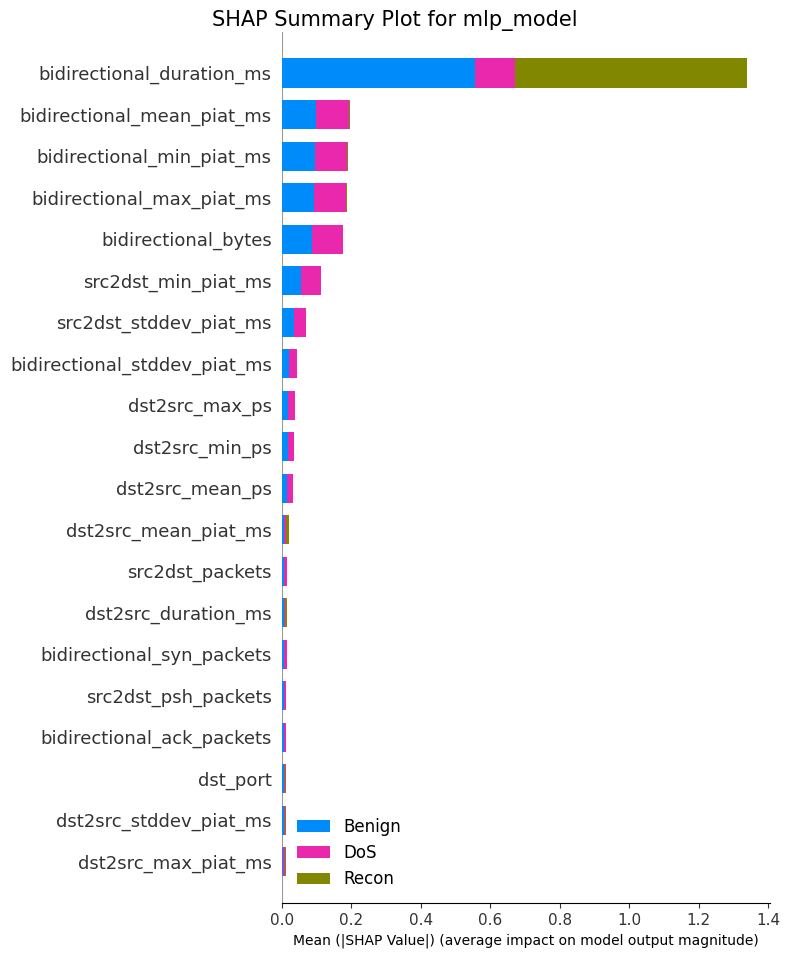

SHAP values computed and saved for mlp_model.


In [35]:
nn_shap_values = compute_and_save_shap_values_mlp(mlp_model, X_train, X_test, 'mlp_model', test_sample_size=1000)

In [8]:
def compute_and_save_shap_values_lstm(model, X_train, X_test, model_name, background_sample_size=100, test_sample_size=1000):
    # Convert DataFrame to NumPy array
    X_train_np = X_train.values
    X_test_np = X_test.values
    
    # Define sequence_length based on your model's expected input
    sequence_length = 1  # Set to 1 if you cannot divide features evenly
    num_features = X_train_np.shape[1]  # This should be the number of features
    
    # Reshape the entire feature set as the "sequence" dimension
    num_features_per_timestep = X_train_np.shape[1]  # This should be the number of features
    
    # Select a contiguous block of data from the training set for background
    start_index = np.random.randint(0, X_train_np.shape[0] - background_sample_size)
    background = X_train_np[start_index:start_index + background_sample_size]
    
    # Reshape background data to match SHAP's expected 2D input shape
    background = background.reshape((background.shape[0], -1))
    
    # Define a prediction function
    def predict(X):
        X = X.reshape((X.shape[0], sequence_length, num_features_per_timestep))  # Reshape input back to 3D for LSTM
        return model.predict(X, verbose=0)
    
    # Select a contiguous block of data from the test set for SHAP analysis
    test_start_index = np.random.randint(0, X_test_np.shape[0] - test_sample_size)
    X_test_sample = X_test_np[test_start_index:test_start_index + test_sample_size]
    
    # Reshape test data to match SHAP's expected 2D input shape
    X_test_sample = X_test_sample.reshape((X_test_sample.shape[0], -1))
    
    # Use KernelExplainer with the prediction function and the summarized background dataset
    kernel_explainer = shap.KernelExplainer(predict, background)

    # Compute SHAP values for the selected test data subset
    shap_values = kernel_explainer.shap_values(X_test_sample)

    # Save the SHAP values for future use
    joblib.dump(shap_values, f'{model_name}_shap_values.joblib')
    
    # Plot SHAP summary plot with feature names
    feature_names = X_test.columns
    
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, show=False)
    
    # Modify the legend to use real class names
    legend = plt.gca().get_legend()
    class_names = ['Benign', 'DoS', 'Recon']
    for i, text in enumerate(legend.get_texts()):
        text.set_text(class_names[i])
        
    plt.gcf().text(0.5, 0.99, f'SHAP Summary Plot for {model_name}', ha='center', fontsize=15)
    plt.xlabel("Mean (|SHAP Value|) (average impact on model output magnitude)", fontsize=10)
    plt.savefig(f'{model_name}_shap_summary_plot_with_title.png', bbox_inches='tight')
    plt.show()
    
    print(f"SHAP values computed and saved for {model_name}.")
    
    return shap_values


2024-09-23 07:05:35.102203: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8905


  0%|          | 0/1000 [00:00<?, ?it/s]

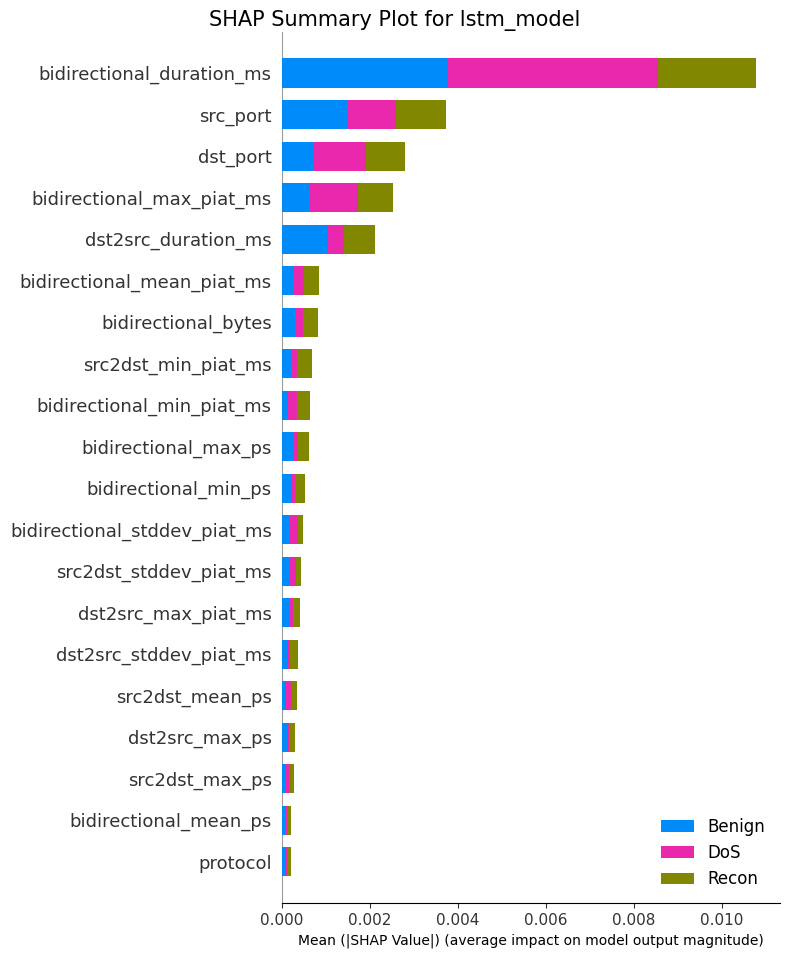

SHAP values computed and saved for lstm_model.


In [9]:
lstm_model_shap_values = compute_and_save_shap_values_lstm(lstm_model, X_train, X_test, 'lstm_model', test_sample_size=1000)

In [7]:
def compute_and_save_shap_values_xgboost(model, X_test, model_name):
    # Convert test data to DMatrix format
    X_test_dmatrix = xgb.DMatrix(X_test)

    # Use TreeExplainer for XGBoost
    xgb_explainer = shap.TreeExplainer(model)

    # Compute SHAP values for the test data
    shap_values = xgb_explainer.shap_values(X_test_dmatrix)

    # Save the SHAP values as a NumPy array
    np.save(f'{model_name}_shap_values.npy', shap_values)
    
    # Save the SHAP values for future use
    joblib.dump(shap_values, f'{model_name}_shap_values.joblib')

    # Plot SHAP summary plot with feature names
    feature_names = X_test.columns
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    
    # Modify the legend to use real class names
    legend = plt.gca().get_legend()
    class_names = ['Benign', 'DoS', 'Recon']
    for i, text in enumerate(legend.get_texts()):
        text.set_text(class_names[i])
    
    # Add a title to the plot and save it
    plt.gcf().text(0.5, 0.99, f'SHAP Summary Plot for {model_name}', ha='center', fontsize=15)
    plt.xlabel("Mean (|SHAP Value|) (average impact on model output magnitude)", fontsize=10)
    plt.savefig(f'{model_name}_shap_summary_plot_with_title.png', bbox_inches='tight')
    plt.show()

    print(f"SHAP values computed and saved for {model_name}.")

    return shap_values

[23:18:27] WARNING: /home/coulombc/wheels_builder/tmp.16977/python-3.10/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


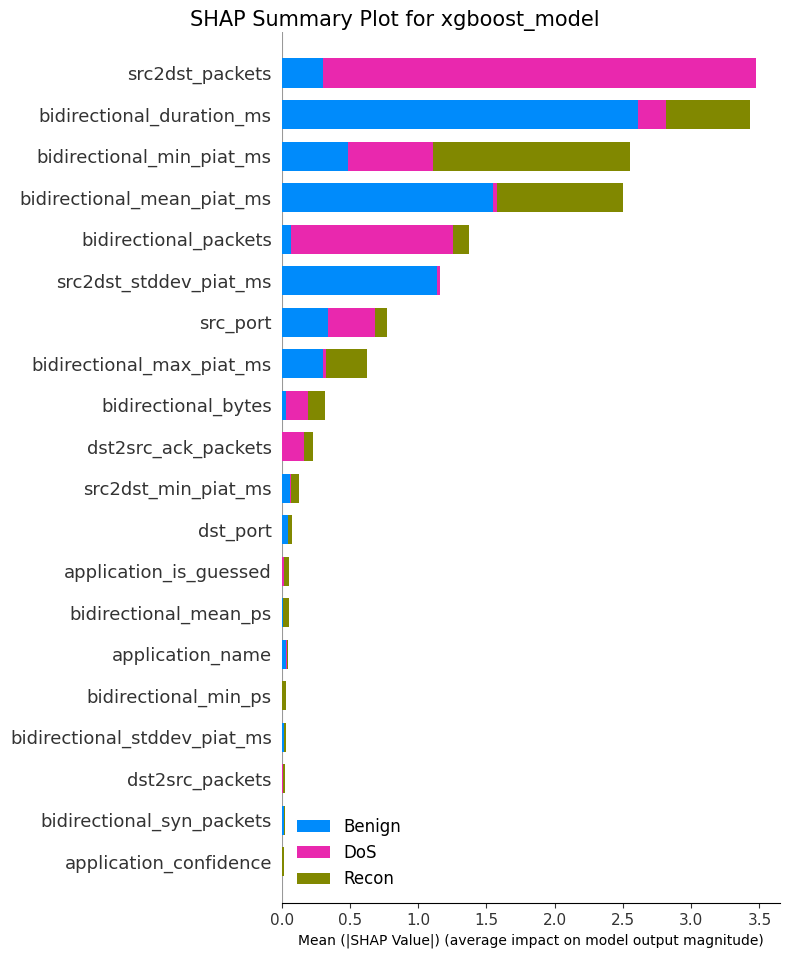

SHAP values computed and saved for xgboost_model.


In [11]:
xgboost_model_shap_values = compute_and_save_shap_values_xgboost(xgboost_model, X_test, 'xgboost_model')